<a href="https://colab.research.google.com/github/Dhruv-Sharma01/Pinn-/blob/main/Rishi_Sir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synthetic hill data saved to synthetic_hill_data.csv


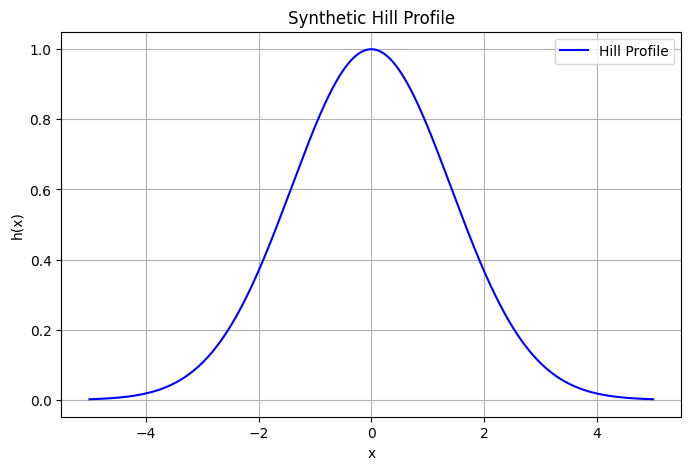

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for the hill profile
A = 1        # Initial hill height
a = 2        # Width of the hill
x_min, x_max = -5, 5  # Spatial domain for x
num_points = 1000     # Number of x points

# Generate x values uniformly across the domain
x_values = np.linspace(x_min, x_max, num_points)

# Compute the hill height at each x using the equation: h(x) = A * exp(-(x/a)^2)
h_values = A * np.exp(-((x_values / a) ** 2))

# Create a DataFrame to hold the data
synthetic_data = pd.DataFrame({'x': x_values, 'h': h_values})

# Save the DataFrame to a CSV file
csv_filename = "synthetic_hill_data.csv"
synthetic_data.to_csv(csv_filename, index=False)
print(f"Synthetic hill data saved to {csv_filename}")

# Plot the hill profile
plt.figure(figsize=(8, 5))
plt.plot(x_values, h_values, label='Hill Profile', color='blue')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.title('Synthetic Hill Profile')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0: Total Loss = 0.419691, IC Loss = 0.254271, PDE Loss = 0.165420
Epoch 500: Total Loss = 0.000346, IC Loss = 0.000252, PDE Loss = 0.000094


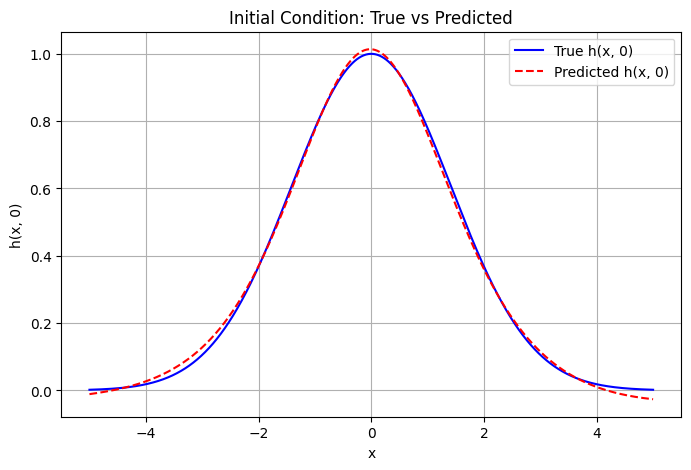

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Load Synthetic Data (Initial Condition at t=0)
csv_filename = "synthetic_hill_data.csv"
synthetic_data = pd.read_csv(csv_filename)

# Extract x and h values (ensure correct shape and type)
x_init_np = synthetic_data['x'].values.reshape(-1, 1).astype(np.float32)
h_init_np = synthetic_data['h'].values.reshape(-1, 1).astype(np.float32)

# Convert to TensorFlow tensors
x_init = tf.convert_to_tensor(x_init_np, dtype=tf.float32)
h_init = tf.convert_to_tensor(h_init_np, dtype=tf.float32)

# 2. Generate Collocation Points for the Space-Time Domain
# Define domain parameters
x_min, x_max = -5, 5
t_min, t_max = 0.0, 1.0
num_colloc = 10000  # number of collocation points

# Randomly sample collocation points in the domain
x_colloc = tf.random.uniform((num_colloc, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
t_colloc = tf.random.uniform((num_colloc, 1), minval=t_min, maxval=t_max, dtype=tf.float32)

# 3. Build the PINN Model
def create_pinn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),  # input: (x, t)
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)  # output: h(x, t)
    ])
    return model

model = create_pinn_model()

# 4. Define the Loss Function (Initial Condition + PDE Residual Loss)
D = 0.1  # Diffusion coefficient

def compute_loss(model, x_init, h_init, x_colloc, t_colloc, D):
    # --- Initial Condition Loss ---
    # At t=0, the network should match the synthetic data.
    t0 = tf.zeros_like(x_init)  # t = 0 for all initial condition points
    inputs_init = tf.concat([x_init, t0], axis=1)
    h_pred_init = model(inputs_init)
    loss_ic = tf.reduce_mean(tf.square(h_pred_init - h_init))

    # --- PDE Residual Loss ---
    # We enforce the PDE at the collocation points.
    # The PDE is: h_t - D * h_xx = 0.
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_colloc)
        tape2.watch(t_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_colloc)
            tape1.watch(t_colloc)
            inputs_colloc = tf.concat([x_colloc, t_colloc], axis=1)
            h_pred_colloc = model(inputs_colloc)
        # First derivatives: h_x and h_t.
        h_x = tape1.gradient(h_pred_colloc, x_colloc)
        h_t = tape1.gradient(h_pred_colloc, t_colloc)
    # Second derivative with respect to x.
    h_xx = tape2.gradient(h_x, x_colloc)
    del tape1, tape2

    # PDE residual: h_t - D * h_xx should be close to 0.
    pde_residual = h_t - D * h_xx
    loss_pde = tf.reduce_mean(tf.square(pde_residual))

    # Total loss: sum of initial condition loss and PDE residual loss.
    total_loss = loss_ic + loss_pde
    return total_loss, loss_ic, loss_pde

# 5. Train the Model Using a Custom Training Loop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 1000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss, loss_ic, loss_pde = compute_loss(model, x_init, h_init, x_colloc, t_colloc, D)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.numpy():.6f}, "
              f"IC Loss = {loss_ic.numpy():.6f}, PDE Loss = {loss_pde.numpy():.6f}")

# 6. Evaluate the Model (Test at t=0)
# For example, predict h(x,0) and compare with synthetic data.
inputs_test = tf.concat([x_init, tf.zeros_like(x_init)], axis=1)
h_pred_test = model(inputs_test)

plt.figure(figsize=(8, 5))
plt.plot(x_init_np, h_init_np, label="True h(x, 0)", color='blue')
plt.plot(x_init_np, h_pred_test.numpy(), '--', label="Predicted h(x, 0)", color='red')
plt.xlabel('x')
plt.ylabel('h(x, 0)')
plt.title("Initial Condition: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


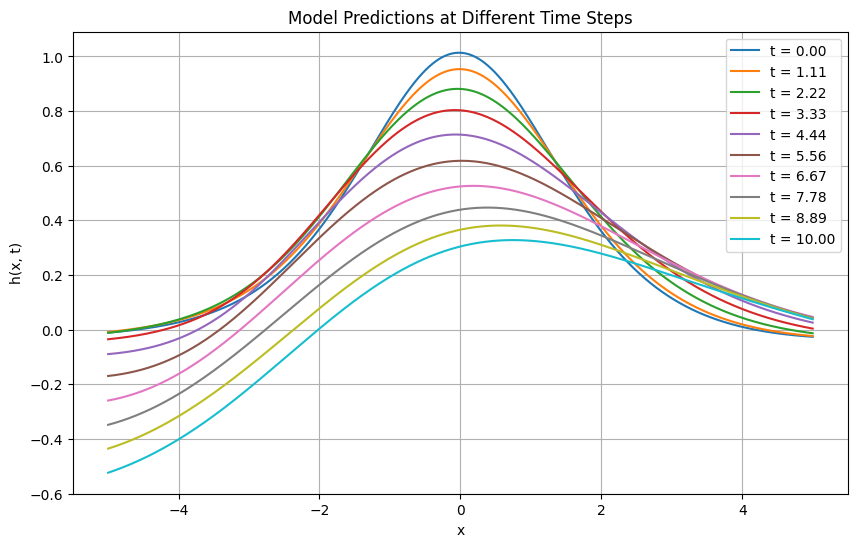

In [ ]:
# Define time steps at which to evaluate the model.
time_steps = np.linspace(0,10,10)
predictions = {}

for t_val in time_steps:
    # Create a tensor for the current time (same shape as x_init)
    t_tensor = tf.ones_like(x_init) * t_val
    inputs = tf.concat([x_init, t_tensor], axis=1)
    h_pred = model(inputs)
    predictions[t_val] = h_pred.numpy()

# Plot the predicted hill profile at different time steps.
plt.figure(figsize=(10, 6))
for t_val in time_steps:
    plt.plot(x_init_np, predictions[t_val], label=f't = {t_val:.2f}')
plt.xlabel('x')
plt.ylabel('h(x, t)')
plt.title("Model Predictions at Different Time Steps")
plt.legend()
plt.grid(True)
plt.show()


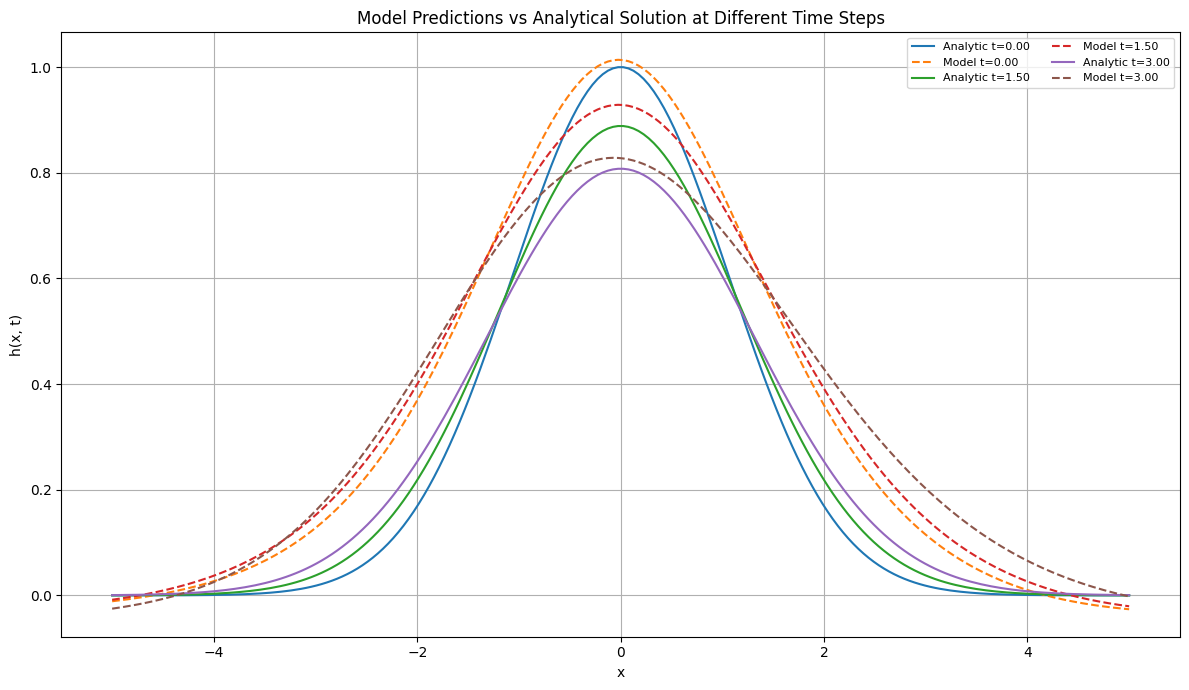

In [ ]:
# --- Define the analytical solution ---
def analytical_solution(x, t, A=1.0, a=1.5, D=0.1):
    return (A * a / np.sqrt(a**2 + 4 * D * t)) * np.exp(-x**2 / (a**2 + 4 * D * t))

# --- Define spatial and temporal range for plotting ---
x_vals = np.linspace(-5, 5, 200).reshape(-1, 1)  # spatial domain
time_steps = np.linspace(0, 3, 3)  # select a few time steps

# --- Plot predictions vs ground truth ---
plt.figure(figsize=(12, 7))

for t in time_steps:
    t_vals = np.full_like(x_vals, t)
    input_tensor = tf.convert_to_tensor(np.hstack((x_vals, t_vals)), dtype=tf.float32)

    # Model prediction
    h_pred = model(input_tensor).numpy().flatten()

    # Analytical solution
    h_true = analytical_solution(x_vals, t).flatten()

    # Plot both
    plt.plot(x_vals, h_true, '-', label=f"Analytic t={t:.2f}")
    plt.plot(x_vals, h_pred, '--', label=f"Model t={t:.2f}")

plt.xlabel("x")
plt.ylabel("h(x, t)")
plt.title("Model Predictions vs Analytical Solution at Different Time Steps")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Compute and print MSE at each time step ---
total_mse = 0.0
for t in time_steps:
    # prepare data again
    t_vals = np.full_like(x_vals, t)
    input_tensor = tf.convert_to_tensor(np.hstack((x_vals, t_vals)), dtype=tf.float32)
    h_pred = model(input_tensor).numpy().flatten()
    h_true = analytical_solution(x_vals, t).flatten()

    mse = mean_squared_error(h_true, h_pred)
    print(f"t = {t:.2f} → MSE = {mse:.6f}")
    total_mse += mse

# --- Print average MSE ---
avg_mse = total_mse / len(time_steps)
print(f"\nAverage MSE over all time steps: {avg_mse:.6f}")


t = 0.00 → MSE = 0.013074
t = 1.50 → MSE = 0.011834
t = 3.00 → MSE = 0.011241

Average MSE over all time steps: 0.012050


### Testing Over Aravalli

In [ ]:
!pip install utm

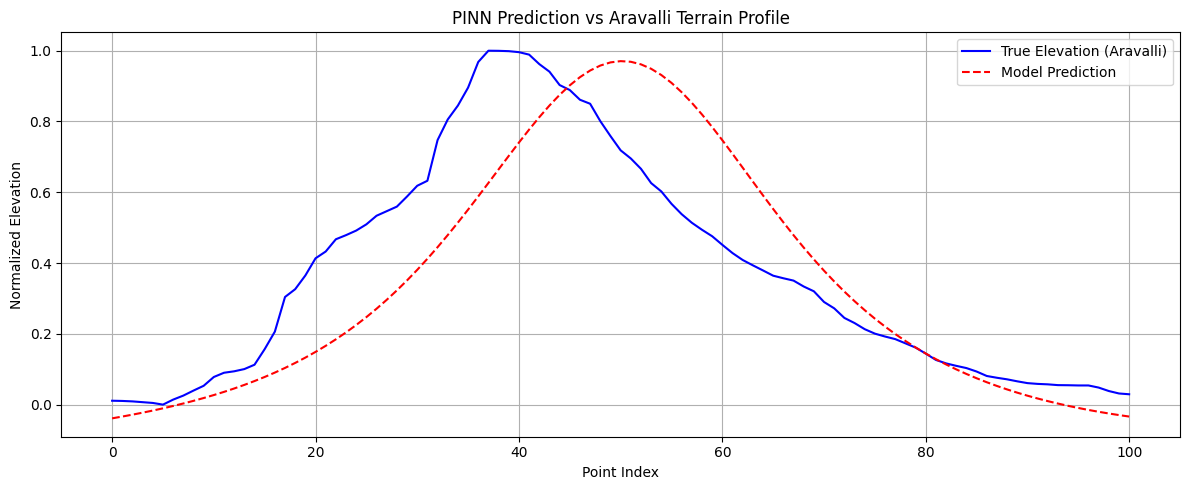

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. Load and Preprocess Aravalli Data ---

def load_aravalli_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip header
    data = [line.strip().split('\t') for line in lines if line.strip()]
    altitudes = [float(row[3]) for row in data]
    return np.array(altitudes)

alt1 = load_aravalli_data("/content/Aravalli range_1.txt")
# alt2 = load_aravalli_data("/content/Aravalli range_2.txt")
altitudes = alt1

# Normalize elevation data
altitudes = (altitudes - np.min(altitudes)) / (np.max(altitudes) - np.min(altitudes))

# Create a pseudo x domain for prediction
num_points = len(altitudes)
x_vals = np.linspace(-5, 5, num_points).reshape(-1, 1).astype(np.float32)
t_val = np.ones_like(x_vals) * 1.0  # Final time for prediction
input_test = tf.convert_to_tensor(np.hstack([x_vals, t_val]), dtype=tf.float32)

# --- 2. Predict using the trained PINN model ---
h_pred = model(input_test).numpy().squeeze()

# --- 3. Plot Results ---
plt.figure(figsize=(12, 5))
plt.plot(altitudes, label='True Elevation (Aravalli)', color='blue')
plt.plot(h_pred, '--', label='Model Prediction', color='red')
plt.xlabel('Point Index')
plt.ylabel('Normalized Elevation')
plt.title('PINN Prediction vs Aravalli Terrain Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


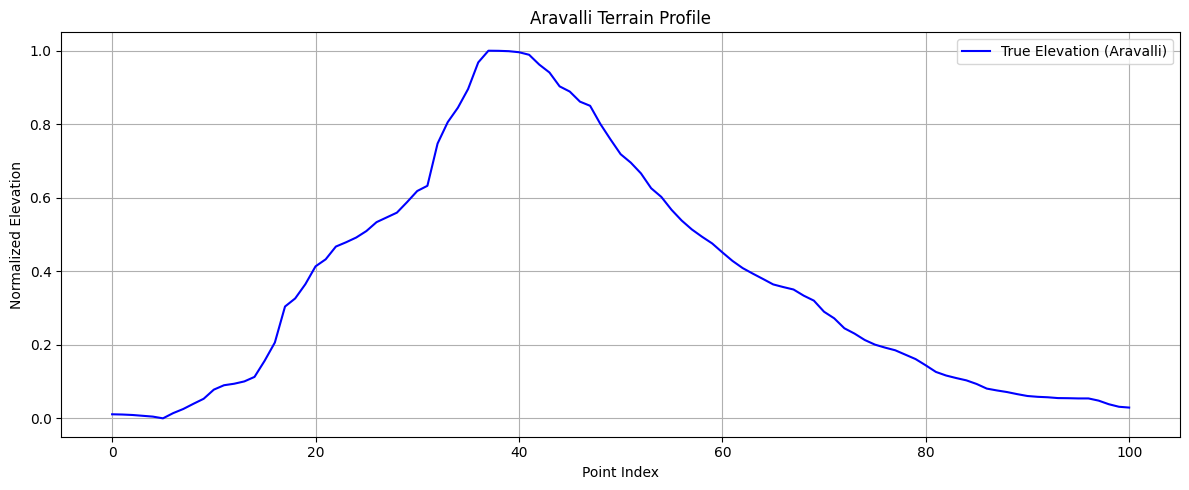

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. Load and Preprocess Aravalli Data ---

def load_aravalli_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip header
    data = [line.strip().split('\t') for line in lines if line.strip()]
    altitudes = [float(row[3]) for row in data]
    return np.array(altitudes)

alt1 = load_aravalli_data("/content/Aravalli range_1.txt")
# alt2 = load_aravalli_data("/content/Aravalli range_2.txt")
altitudes = alt1

# Normalize elevation data
altitudes = (altitudes - np.min(altitudes)) / (np.max(altitudes) - np.min(altitudes))

# Create a pseudo x domain for prediction
num_points = len(altitudes)
x_vals = np.linspace(-5, 5, num_points).reshape(-1, 1).astype(np.float32)
t_val = np.ones_like(x_vals) * 1.0  # Final time for prediction
input_test = tf.convert_to_tensor(np.hstack([x_vals, t_val]), dtype=tf.float32)

# --- 2. Predict using the trained PINN model ---
# h_pred = model(input_test).numpy().squeeze()

# --- 3. Plot Results ---
plt.figure(figsize=(12, 5))
plt.plot(altitudes, label='True Elevation (Aravalli)', color='blue')
# plt.plot(h_pred, '--', label='Model Prediction', color='red')
plt.xlabel('Point Index')
plt.ylabel('Normalized Elevation')
plt.title('Aravalli Terrain Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Boundary Condition of Aravalli

In [ ]:
# 1. Use Aravalli as Initial Condition
x_aravalli = x_vals  # already from np.linspace(-5, 5, N)
h_aravalli = altitudes.reshape(-1, 1).astype(np.float32)

# Convert to tensors
x_init = tf.convert_to_tensor(x_aravalli, dtype=tf.float32)
h_init = tf.convert_to_tensor(h_aravalli, dtype=tf.float32)

# 2. (No change needed to collocation points, already defined as:)
# x_colloc, t_colloc

# 3. Rebuild the model (optional, to reset weights)
model = create_pinn_model()

# 4. Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 1000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss, loss_ic, loss_pde = compute_loss(model, x_init, h_init, x_colloc, t_colloc, D)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.numpy():.6f}, "
              f"IC Loss = {loss_ic.numpy():.6f}, PDE Loss = {loss_pde.numpy():.6f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0: Total Loss = 0.243711, IC Loss = 0.236242, PDE Loss = 0.007469
Epoch 100: Total Loss = 0.007806, IC Loss = 0.007564, PDE Loss = 0.000241
Epoch 200: Total Loss = 0.003500, IC Loss = 0.003319, PDE Loss = 0.000181
Epoch 300: Total Loss = 0.001869, IC Loss = 0.001692, PDE Loss = 0.000176
Epoch 400: Total Loss = 0.001379, IC Loss = 0.001229, PDE Loss = 0.000150
Epoch 500: Total Loss = 0.001219, IC Loss = 0.001093, PDE Loss = 0.000127
Epoch 600: Total Loss = 0.001113, IC Loss = 0.001001, PDE Loss = 0.000112
Epoch 700: Total Loss = 0.001055, IC Loss = 0.000958, PDE Loss = 0.000097
Epoch 800: Total Loss = 0.001096, IC Loss = 0.001015, PDE Loss = 0.000080
Epoch 900: Total Loss = 0.000978, IC Loss = 0.000914, PDE Loss = 0.000064


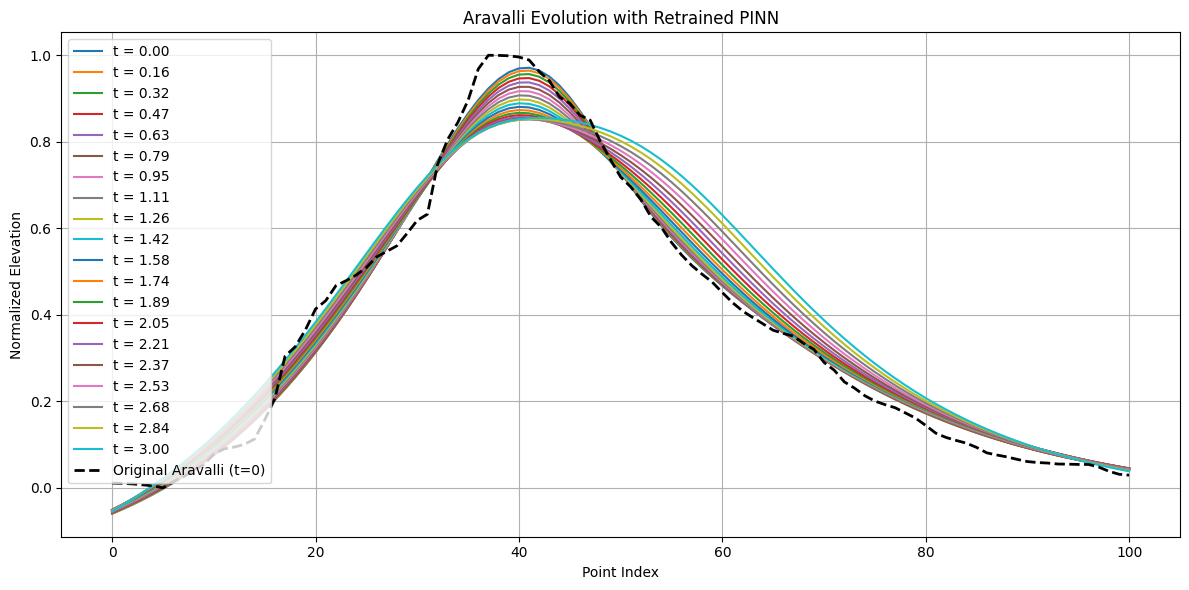

In [ ]:
timesteps = np.linspace(0, 3,20)

plt.figure(figsize=(12, 6))
for t in timesteps:
    t_col = np.full_like(x_aravalli, fill_value=t, dtype=np.float32)
    input_t = tf.convert_to_tensor(np.hstack([x_aravalli, t_col]), dtype=tf.float32)
    h_t_pred = model(input_t).numpy().squeeze()
    plt.plot(h_t_pred, label=f't = {t:.2f}')

# Original Aravalli profile
plt.plot(altitudes, 'k--', linewidth=2, label='Original Aravalli (t=0)')
plt.xlabel("Point Index")
plt.ylabel("Normalized Elevation")
plt.title("Aravalli Evolution with Retrained PINN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0: Total Loss = 1.430694, IC Loss = 1.430433, PDE Loss = 0.026007
Epoch 100: Total Loss = 0.017593, IC Loss = 0.017589, PDE Loss = 0.000413
Epoch 200: Total Loss = 0.007967, IC Loss = 0.007941, PDE Loss = 0.000269
Epoch 300: Total Loss = 0.005050, IC Loss = 0.005039, PDE Loss = 0.000113
Epoch 400: Total Loss = 0.003470, IC Loss = 0.003460, PDE Loss = 0.000097
Epoch 500: Total Loss = 0.002424, IC Loss = 0.002415, PDE Loss = 0.000089
Epoch 600: Total Loss = 0.001695, IC Loss = 0.001687, PDE Loss = 0.000088
Epoch 700: Total Loss = 0.001276, IC Loss = 0.001267, PDE Loss = 0.000089
Epoch 800: Total Loss = 0.001096, IC Loss = 0.001088, PDE Loss = 0.000088
Epoch 900: Total Loss = 0.001032, IC Loss = 0.001024, PDE Loss = 0.000085


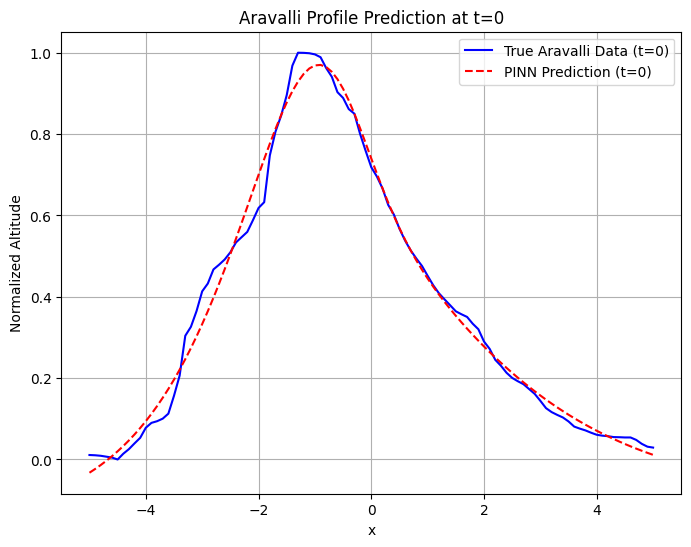

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. Load and Process Aravalli Data ---
# Read the tab-separated file (update the file path if needed)
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')

# Extract the altitude values (column "altitude (m)")
# Note: We use column index 3 or the column name "altitude (m)"
altitudes = data["altitude (m)"].values.astype(np.float32)

# Normalize the altitude values (optional but helps training)
altitudes_norm = (altitudes - np.min(altitudes)) / (np.max(altitudes) - np.min(altitudes))

# Create x-coordinates for the profile using a linspace over [-5, 5]
# The number of points matches the number of altitude values.
x_aravalli = np.linspace(-5, 5, len(altitudes_norm)).reshape(-1, 1).astype(np.float32)

# Convert to TensorFlow tensors
x_init = tf.convert_to_tensor(x_aravalli, dtype=tf.float32)
h_init = tf.convert_to_tensor(altitudes_norm.reshape(-1, 1), dtype=tf.float32)

# --- 2. Generate Collocation Points in the Space-Time Domain ---
x_min, x_max = -5, 5
t_min, t_max = 0.0, 1.0
num_colloc = 10000

x_colloc = tf.random.uniform((num_colloc, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
t_colloc = tf.random.uniform((num_colloc, 1), minval=t_min, maxval=t_max, dtype=tf.float32)

# --- 3. Build the PINN Model ---
def create_pinn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),  # Inputs: (x, t)
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)  # Output: h(x,t)
    ])
    return model

model = create_pinn_model()

# --- 4. Define the Loss Function (IC Loss + PDE Residual Loss) ---
D = 0.1  # Diffusion coefficient

def compute_loss(model, x_init, h_init, x_colloc, t_colloc, D, lambda_ic, lambda_pde):
    # --- Initial Condition Loss ---
    # At t=0, enforce h(x,0) = h_init
    t0 = tf.zeros_like(x_init)
    inputs_ic = tf.concat([x_init, t0], axis=1)
    h_pred_ic = model(inputs_ic)
    loss_ic = tf.reduce_mean(tf.square(h_pred_ic - h_init))

    # --- PDE Residual Loss ---
    # The PDE is: h_t - D * h_xx = 0.
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_colloc)
        tape2.watch(t_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_colloc)
            tape1.watch(t_colloc)
            inputs_colloc = tf.concat([x_colloc, t_colloc], axis=1)
            h_pred_colloc = model(inputs_colloc)
        h_x = tape1.gradient(h_pred_colloc, x_colloc)
        h_t = tape1.gradient(h_pred_colloc, t_colloc)
    h_xx = tape2.gradient(h_x, x_colloc)
    del tape1, tape2

    pde_res = h_t - D * h_xx
    loss_pde = tf.reduce_mean(tf.square(pde_res))

    total_loss = lambda_ic * loss_ic + lambda_pde * loss_pde
    return total_loss, loss_ic, loss_pde

# --- 5. Train the PINN Using a Custom Training Loop ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 1000
loss_history = []

for epoch in range(epochs):
    # Use a simple curriculum: for early epochs, focus on the initial condition
    if epoch < 200:
        current_lambda_ic = 1.0
        current_lambda_pde = 0.01
    else:
        current_lambda_ic = 1.0
        current_lambda_pde = 0.1

    with tf.GradientTape() as tape:
        total_loss, loss_ic, loss_pde = compute_loss(
            model, x_init, h_init, x_colloc, t_colloc, D,
            current_lambda_ic, current_lambda_pde
        )
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_history.append(total_loss.numpy())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.numpy():.6f}, "
              f"IC Loss = {loss_ic.numpy():.6f}, PDE Loss = {loss_pde.numpy():.6f}")

# --- 6. Plot the PINN Prediction at t=0 ---
t0_pred = tf.zeros_like(x_init)
inputs_plot = tf.concat([x_init, t0_pred], axis=1)
h_pred_plot = model(inputs_plot).numpy()

plt.figure(figsize=(8,6))
plt.plot(x_aravalli, altitudes_norm, 'b-', label='True Aravalli Data (t=0)')
plt.plot(x_aravalli, h_pred_plot, 'r--', label='PINN Prediction (t=0)')
plt.xlabel('x')
plt.ylabel('Normalized Altitude')
plt.title('Aravalli Profile Prediction at t=0')
plt.legend()
plt.grid(True)
plt.show()


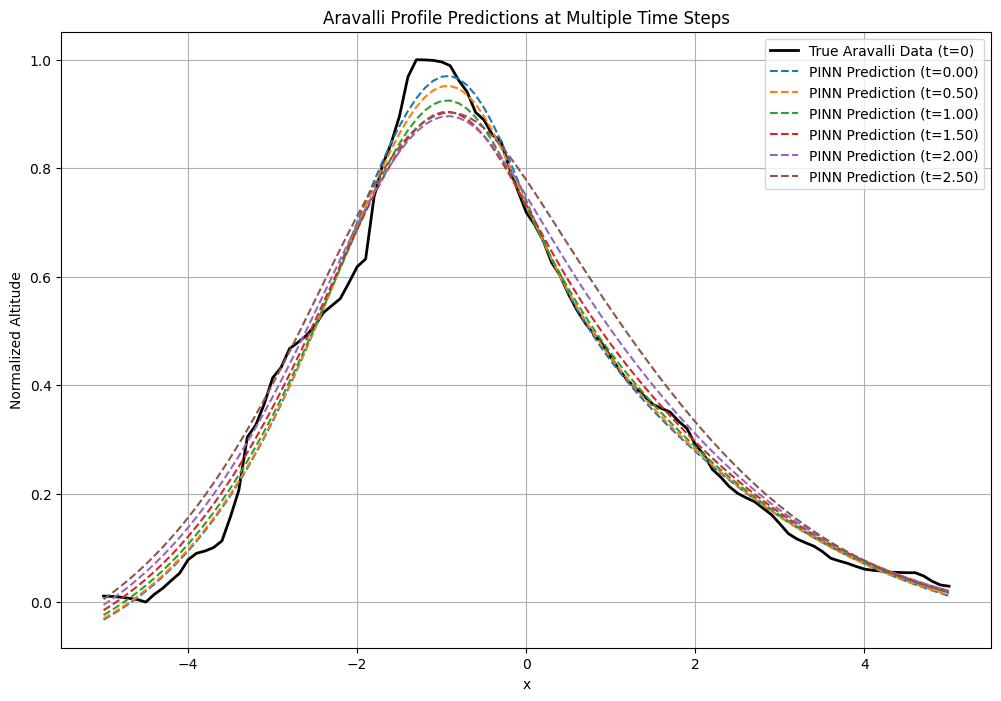

In [ ]:
time_steps = np.linspace(0, 3, 3)
predictions = {}
for t_val in time_steps:
    t_tensor = tf.ones_like(x_init) * t_val
    inputs_pred = tf.concat([x_init, t_tensor], axis=1)
    h_pred = model(inputs_pred).numpy().squeeze()
    predictions[t_val] = h_pred

# --- 7. Plot the Predictions ---
plt.figure(figsize=(12, 8))
# Plot the true data at t=0
plt.plot(x_aravalli, altitudes_norm, 'k-', label='True Aravalli Data (t=0)', linewidth=2)

# Plot predictions for all specified time steps
for t_val in time_steps:
    plt.plot(x_aravalli, predictions[t_val], '--', label=f'PINN Prediction (t={t_val:.2f})', linewidth=1.5)

plt.xlabel('x')
plt.ylabel('Normalized Altitude')
plt.title('Aravalli Profile Predictions at Multiple Time Steps')
plt.legend()
plt.grid(True)
plt.show()

t = 0.00 → MSE = 0.000998
t = 0.50 → MSE = 0.000296


<ipython-input-13-d13d9db9e685>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max())


t = 1.00 → MSE = 0.000122


<ipython-input-13-d13d9db9e685>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max())


t = 1.50 → MSE = 0.000087


<ipython-input-13-d13d9db9e685>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max())


t = 2.00 → MSE = 0.000362


<ipython-input-13-d13d9db9e685>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max())


t = 2.50 → MSE = 0.001522

Average MSE over all time steps: 0.000564


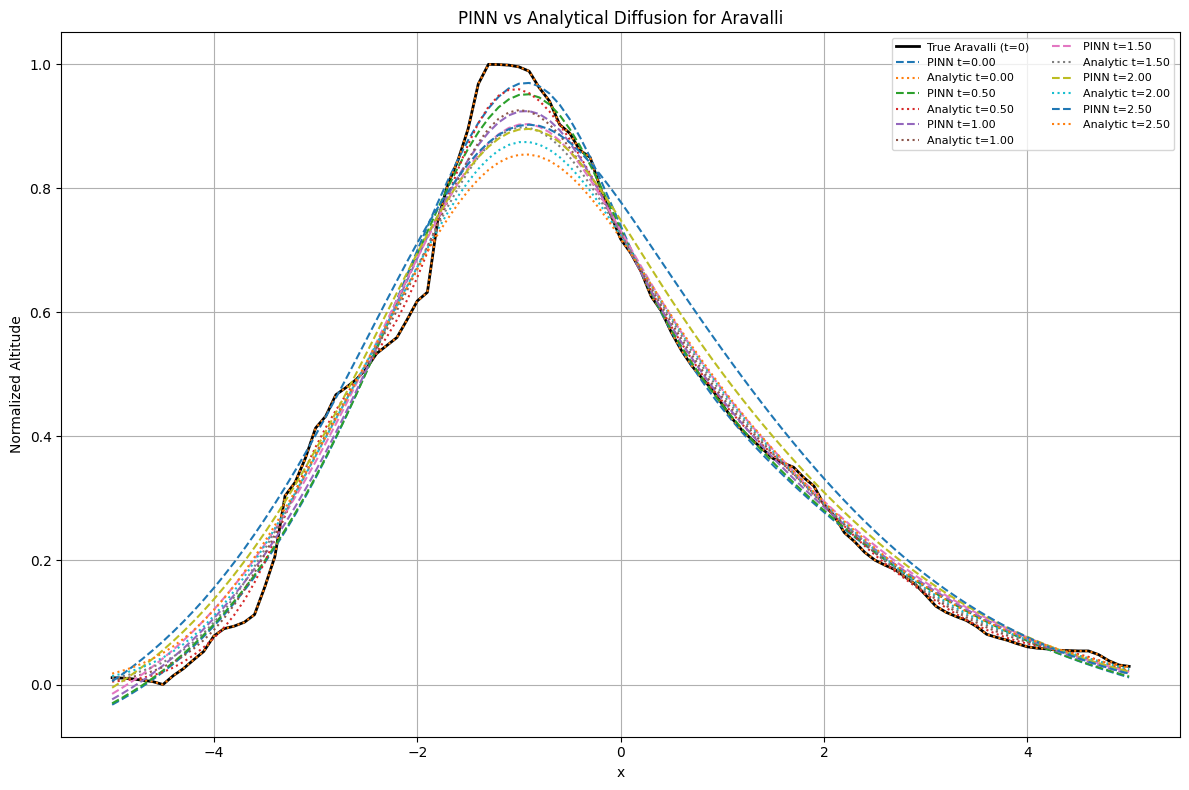

In [ ]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error

# ————————————————————————————————
# 8. Build interpolant of h0(x)
# ————————————————————————————————
h0_interp_np = interp1d(
    x_aravalli.flatten(),
    altitudes_norm.flatten(),
    kind='cubic',
    fill_value=0.0,
    bounds_error=False
)

# ————————————————————————————————
# 9. Analytical solution for an arbitrary h0(x)
# ————————————————————————————————
def analytical_solution_aravalli(x_vals, t, D=0.1):
    if t == 0:
        return h0_interp_np(x_vals.flatten())
    sol = []
    for x in x_vals.flatten():
        # kernel * h0 convolution
        integrand = lambda xi: (
            h0_interp_np(xi)
            * np.exp(-(x - xi)**2 / (4 * D * t))
            / np.sqrt(4 * np.pi * D * t)
        )
        val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max())
        sol.append(val)
    return np.array(sol)

# ————————————————————————————————
# 10. Re‑plot predictions + analytical + compute MSE
# ————————————————————————————————
plt.figure(figsize=(12, 8))
plt.plot(x_aravalli, altitudes_norm, 'k-', label='True Aravalli (t=0)', linewidth=2)

mse_list = []
for t_val in time_steps:
    # PINN prediction (you already have in `predictions[t_val]`)
    h_pred = predictions[t_val]
    plt.plot(x_aravalli, h_pred, '-', label=f'PINN t={t_val:.2f}')

    # Analytical solution
    h_analytical = analytical_solution_aravalli(x_aravalli, t_val, D=0.1)
    plt.plot(x_aravalli, h_analytical, ':', label=f'Analytic t={t_val:.2f}')

    # compute MSE
    mse = mean_squared_error(h_analytical, h_pred)
    print(f"t = {t_val:.2f} → MSE = {mse:.6f}")
    mse_list.append(mse)

# average MSE
avg_mse = np.mean(mse_list)
print(f"\nAverage MSE over all time steps: {avg_mse:.6f}")

plt.xlabel('x')
plt.ylabel('Normalized Altitude')
plt.title('PINN vs Analytical Diffusion for Aravalli')
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


t = 0.00 → MSE = 0.000998


<ipython-input-17-69fb6c01c569>:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(


t = 2.00 → MSE = 0.000362


<ipython-input-17-69fb6c01c569>:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(


t = 4.00 → MSE = 0.019000

Average MSE over all time steps: 0.006787


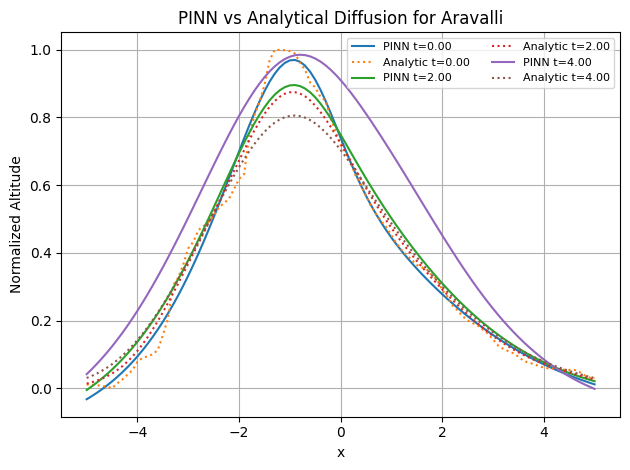

In [ ]:
time_steps = np.linspace(0, 4, 3)
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error

mse_list = []

for t_val in time_steps:
    # --- 1) PINN prediction at time t_val ---
    t_tensor = tf.ones_like(x_init) * float(t_val)
    inputs_pred = tf.concat([x_init, t_tensor], axis=1)
    h_pred = model(inputs_pred).numpy().flatten()
    plt.plot(x_aravalli, h_pred, '-', label=f'PINN t={t_val:.2f}')

    # --- 2) Analytical solution at t_val ---
    if t_val == 0.0:
        # at t=0, analytical = initial profile
        h_analytical = h0_interp_np(x_aravalli.flatten())
    else:
        # increase max subdivisions via `limit=100`
        sol = []
        for x in x_aravalli.flatten():
            integrand = lambda xi: (
                h0_interp_np(xi)
                * np.exp(-((x - xi)**2) / (4 * D * t_val))
                / np.sqrt(4 * np.pi * D * t_val)
            )
            val, _ = quad(
                integrand,
                x_aravalli.min(),
                x_aravalli.max(),
                limit=100
            )
            sol.append(val)
        h_analytical = np.array(sol)

    plt.plot(x_aravalli, h_analytical, ':', label=f'Analytic t={t_val:.2f}')

    # --- 3) Compute MSE ---
    mse = mean_squared_error(h_analytical, h_pred)
    print(f"t = {t_val:.2f} → MSE = {mse:.6f}")
    mse_list.append(mse)

# --- 4) Average MSE ---
avg_mse = np.mean(mse_list)
print(f"\nAverage MSE over all time steps: {avg_mse:.6f}")

plt.xlabel('x')
plt.ylabel('Normalized Altitude')
plt.title('PINN vs Analytical Diffusion for Aravalli')
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


### Infinite Time Boundary Condition

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. Load and Process Aravalli Data ---
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')
altitudes = data["altitude (m)"].values.astype(np.float32)
altitudes_norm = (altitudes - altitudes.min()) / (altitudes.max() - altitudes.min())
x_aravalli = np.linspace(-5, 5, len(altitudes_norm)).reshape(-1, 1).astype(np.float32)
x_init = tf.convert_to_tensor(x_aravalli, dtype=tf.float32)
h_init = tf.convert_to_tensor(altitudes_norm.reshape(-1, 1), dtype=tf.float32)

# --- 2. Collocation & BC Points ---
x_min, x_max = -5, 5
t_min, t_max = 0.0, 1.0
num_colloc = 10000
num_bc    = 1000         # number of BC points

x_colloc = tf.random.uniform((num_colloc, 1), x_min, x_max)
t_colloc = tf.random.uniform((num_colloc, 1), t_min, t_max)

# boundary‑at‑infinity approximated at T_inf
T_inf = 5.0
x_bc = tf.random.uniform((num_bc, 1), x_min, x_max)

# --- 3. Build the PINN Model ---
def create_pinn_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

model = create_pinn_model()

# --- 4. Loss Function with IC, PDE, and BC ---
D = 0.1  # diffusion coefficient

def compute_loss(model, x_init, h_init, x_colloc, t_colloc, x_bc, D,
                 λ_ic, λ_pde, λ_bc, T_inf):
    # Initial Condition Loss
    t0 = tf.zeros_like(x_init)
    h_ic = model(tf.concat([x_init, t0], axis=1))
    loss_ic = tf.reduce_mean((h_ic - h_init)**2)

    # PDE Residual Loss
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_colloc); tape2.watch(t_colloc)
        with tf.GradientTape(persistent=True) as tape1:

            tape1.watch(x_colloc); tape1.watch(t_colloc)
            h_colloc = model(tf.concat([x_colloc, t_colloc], axis=1))
        h_x = tape1.gradient(h_colloc, x_colloc)
        h_t = tape1.gradient(h_colloc, t_colloc)
    h_xx = tape2.gradient(h_x, x_colloc)
    del tape1, tape2

    loss_pde = tf.reduce_mean((h_t - D * h_xx)**2)

    # Boundary Condition Loss at t = T_inf
    t_inf = tf.ones_like(x_bc) * T_inf
    h_inf = model(tf.concat([x_bc, t_inf], axis=1))
    loss_bc = tf.reduce_mean(h_inf**2)  # want h_inf → 0

    # Total
    total = λ_ic * loss_ic + λ_pde * loss_pde + λ_bc * loss_bc
    return total, loss_ic, loss_pde, loss_bc

# --- 5. Training Loop ---
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 1000

# weights for each term
λ_ic  = 1.0
λ_pde = 0.1
λ_bc  = 0.1

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        tot, lic, lpde, lbc = compute_loss(
            model, x_init, h_init,
            x_colloc, t_colloc, x_bc,
            D, λ_ic, λ_pde, λ_bc, T_inf
        )
    grads = tape.gradient(tot, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total={tot.numpy():.4f}, "
              f"IC={lic.numpy():.4f}, PDE={lpde.numpy():.4f}, BC={lbc.numpy():.4f}")

# --- 6. Plot Predictions at Multiple Times ---
plt.figure(figsize=(10, 6))
time_steps = [0.0, 0.5, 1.0, 2.5, 5.0]
for t in time_steps:
    x_t = tf.concat([x_init, tf.ones_like(x_init)*t], axis=1)
    h_pred = model(x_t).numpy().squeeze()
    plt.plot(x_aravalli, h_pred, '--', label=f'PINN t={t:.1f}')

# also plot initial data
plt.plot(x_aravalli, altitudes_norm, 'k-', label='True Aravalli (t=0)')
plt.xlabel('x'); plt.ylabel('Normalized Elevation')
plt.title('Hillslope Evolution with IC, PDE & BC(t→∞)')
plt.legend(); plt.grid(); plt.show()


ValueError: Cannot convert '2' to a shape.

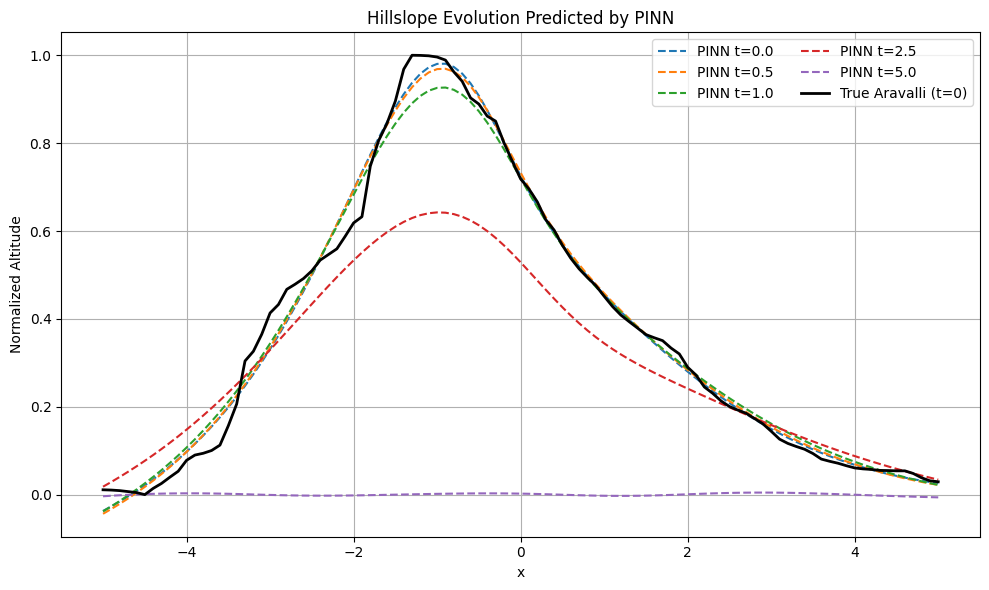

In [ ]:
# --- Plot PINN Predictions at Different Time Steps ---

# Define time steps you want to evaluate
time_steps = [0.0, 0.5, 1.0, 2.5, 5.0]  # include T_inf

plt.figure(figsize=(10, 6))

for t in time_steps:
    t_input = tf.ones_like(x_init) * t  # shape [N, 1]
    input_t = tf.concat([x_init, t_input], axis=1)  # shape [N, 2]
    h_pred_t = model(input_t).numpy().squeeze()
    plt.plot(x_aravalli, h_pred_t, '--', label=f'PINN t={t:.1f}')

# Plot true t=0 Aravalli profile for reference
plt.plot(x_aravalli, altitudes_norm, 'k-', label='True Aravalli (t=0)', linewidth=2)

plt.xlabel('x')
plt.ylabel('Normalized Altitude')
plt.title('Hillslope Evolution Predicted by PINN')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Utility: analytic diffusion solver for comparison ---
def analytic_neumann(h0, D, t, dx):
    from scipy.fftpack import dct, idct
    H0 = dct(h0, type=2, norm="ortho")
    k = np.arange(len(h0))
    L = dx * (len(h0) - 1)
    lam = (np.pi * k / L)**2
    Ht = H0 * np.exp(-D * lam * t)
    return idct(Ht, type=2, norm="ortho")

# --- 1. Load and Normalize Aravalli Elevation Data ---
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')
altitudes = data['altitude (m)'].astype(np.float32).values
# Normalize elevation to [0,1]
alt_min, alt_max = altitudes.min(), altitudes.max()
altitudes_norm = (altitudes - alt_min) / (alt_max - alt_min)
# Spatial coordinate x in [-1,1]
N = len(altitudes_norm)
x = np.linspace(-1, 1, N, dtype=np.float32).reshape(-1,1)

# Convert to tensors for IC
tf_x_init = tf.convert_to_tensor(x)
tf_h_init = tf.convert_to_tensor(altitudes_norm.reshape(-1,1))

# --- 2. PINN Collocation and Boundary Sampling ---
T_inf = 750.0  # end time in years to enforce BC
num_colloc = 20000
x_colloc = tf.random.uniform((num_colloc,1), -1.0, 1.0)
t_colloc = tf.random.uniform((num_colloc,1), 0.0, T_inf)
# Boundary at t = T_inf
num_bc = 2000
x_bc = tf.random.uniform((num_bc,1), -1.0, 1.0)

dx = (1 - (-1)) / (N-1)  # spacing in normalized x
diffusivity = 0.1  # m^2/yr

# --- 3. Build PINN Model ---
activation = tf.keras.activations.tanh
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# --- 4. Physics-Informed Loss Function ---
@tf.function
def compute_loss():
    # Initial condition loss: h(x,0) = data
    t0 = tf.zeros_like(tf_x_init)
    h0_pred = model(tf.concat([tf_x_init, t0], axis=1))
    loss_ic = tf.reduce_mean(tf.square(h0_pred - tf_h_init))

    # PDE residual at collocation points
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x_colloc, t_colloc])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x_colloc, t_colloc])
            ht = model(tf.concat([x_colloc, t_colloc], axis=1))
        h_x = tape1.gradient(ht, x_colloc)
        h_t = tape1.gradient(ht, t_colloc)
    h_xx = tape2.gradient(h_x, x_colloc)
    loss_pde = tf.reduce_mean(tf.square(h_t - diffusivity * h_xx))
    del tape1, tape2

    # Boundary condition at t = T_inf: h -> 0
    t_inf = tf.ones_like(x_bc) * T_inf
    h_inf = model(tf.concat([x_bc, t_inf], axis=1))
    loss_bc = tf.reduce_mean(tf.square(h_inf))

    total_loss = loss_ic + 0.1 * loss_pde + 0.1 * loss_bc
    return total_loss, loss_ic, loss_pde, loss_bc

# --- 5. Training Loop ---
epochs = 1200
for epoch in range(1, epochs+1):
    with tf.GradientTape() as tape:
        total, ic, pde, bc = compute_loss()
    grads = tape.gradient(total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 200 == 0 or epoch == 1:
        tf.print("Epoch", epoch,
                 "Total", total,
                 "IC", ic,
                 "PDE", pde,
                 "BC", bc)

# --- 6. Predict and Plot at t=50 and t=750 ---


Epoch 1 Total 0.317690969 IC 0.275325656 PDE 8.63822133e-05 BC 0.423566699
Epoch 200 Total 0.00626783259 IC 0.0062621166 PDE 5.67236675e-05 BC 4.35572929e-07
Epoch 400 Total 0.00125497964 IC 0.00124739227 PDE 7.57103699e-05 BC 1.63491e-07
Epoch 600 Total 0.00102701364 IC 0.00101849134 PDE 8.51351942e-05 BC 8.74856e-08
Epoch 800 Total 0.000958356424 IC 0.000951438094 PDE 6.91418536e-05 BC 4.14757757e-08
Epoch 1000 Total 0.000907663489 IC 0.000901839056 PDE 5.7510857e-05 BC 7.33254922e-07
Epoch 1200 Total 0.000879883766 IC 0.000875627215 PDE 4.18975433e-05 BC 6.68221503e-07


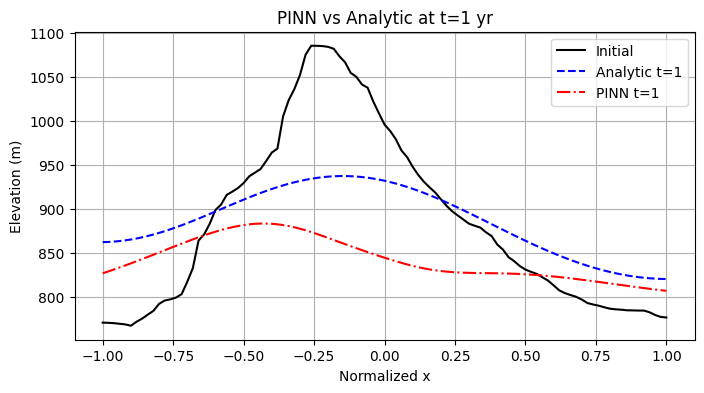

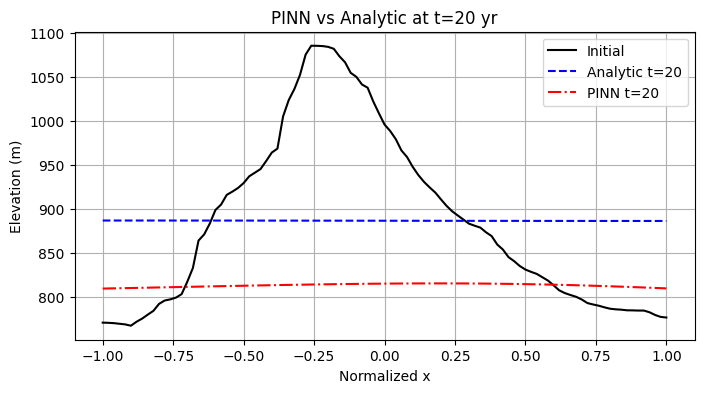

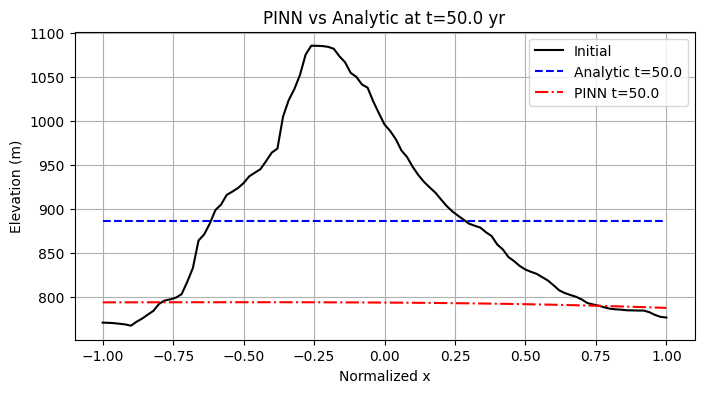

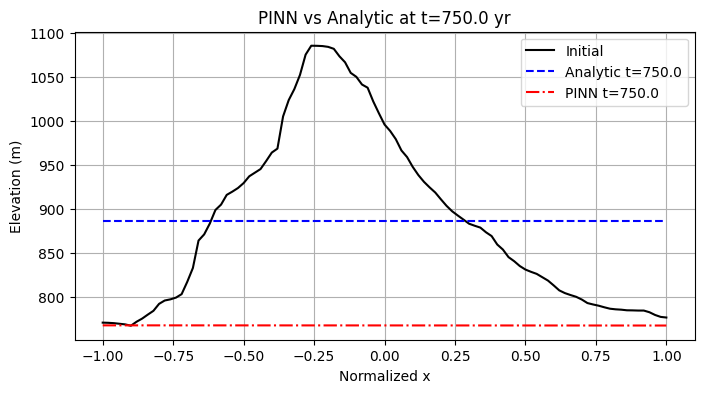

In [ ]:
for t_val in [1,20,50.0, 750.0]:
    t_tensor = tf.ones_like(x) * t_val
    h_pred_norm = model(tf.concat([x, t_tensor], axis=1)).numpy().squeeze()
    h_pred = h_pred_norm * (alt_max - alt_min) + alt_min

    # Ground truth analytic
    h_true_norm = analytic_neumann(altitudes_norm, diffusivity, t_val, dx)
    h_true = h_true_norm * (alt_max - alt_min) + alt_min

    plt.figure(figsize=(8,4))
    plt.plot(x.flatten(), altitudes_norm*(alt_max-alt_min)+alt_min, 'k-', label='Initial')
    plt.plot(x.flatten(), h_true, 'b--', label=f'Analytic t={t_val}')
    plt.plot(x.flatten(), h_pred, 'r-.', label=f'PINN t={t_val}')
    plt.xlabel('Normalized x')
    plt.ylabel('Elevation (m)')
    plt.title(f'PINN vs Analytic at t={t_val} yr')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1 Total 1.02609515 IC 0.236034885 PDE 0.000119560267 BC 1.15849268 SUP 1.34839809
Epoch 200 Total 0.0306520034 IC 0.0161830373 PDE 0.000114665461 BC 0.0540749878 SUP 0.0181


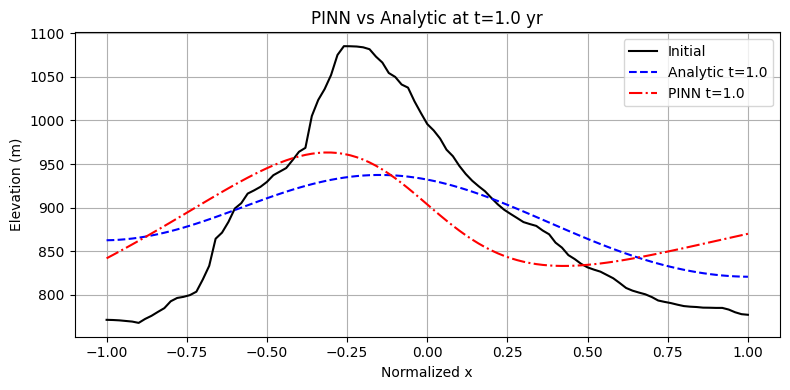

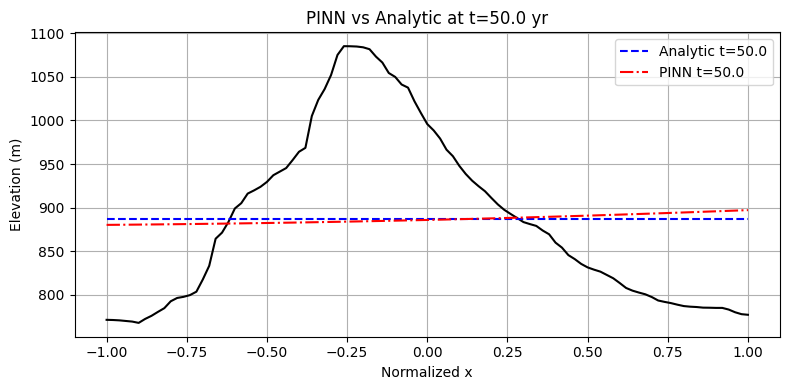

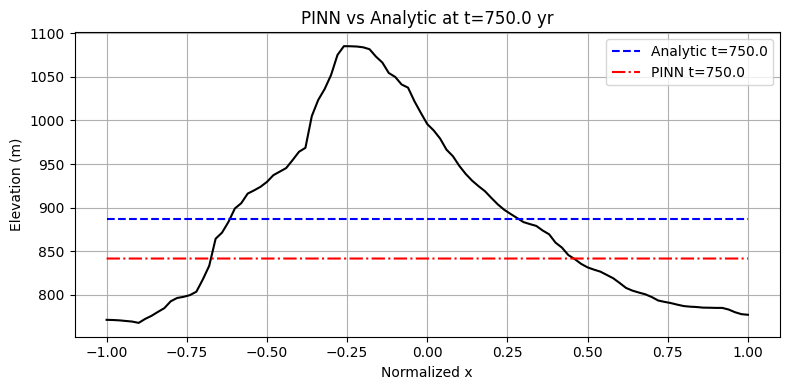

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Utility: analytic diffusion solver for comparison ---
from scipy.fftpack import dct, idct

def analytic_neumann(h0, D, t, dx):
    H0 = dct(h0, type=2, norm="ortho")
    k = np.arange(len(h0))
    L = dx * (len(h0) - 1)
    lam = (np.pi * k / L)**2
    Ht = H0 * np.exp(-D * lam * t)
    return idct(Ht, type=2, norm="ortho")

# --- 1. Load and Normalize Aravalli Elevation Data ---
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')
altitudes = data['altitude (m)'].astype(np.float32).values
# Normalize elevation to [0,1]
alt_min, alt_max = altitudes.min(), altitudes.max()
altitudes_norm = (altitudes - alt_min) / (alt_max - alt_min)
# Spatial coordinate x in [-1,1]
N = len(altitudes_norm)
x = np.linspace(-1, 1, N, dtype=np.float32).reshape(-1,1)

# Convert to tensors for IC
tf_x_init = tf.convert_to_tensor(x)
tf_h_init = tf.convert_to_tensor(altitudes_norm.reshape(-1,1))

# --- 2. PINN Collocation, Boundary, and Supervision Sampling ---
T_inf = 750.0  # end time in years to enforce BC
num_colloc = 20000
x_colloc = tf.random.uniform((num_colloc,1), -1.0, 1.0)
t_colloc = tf.random.uniform((num_colloc,1), 0.0, T_inf)
# Boundary at t = T_inf
um_bc = 2000
x_bc = tf.random.uniform((num_bc,1), -1.0, 1.0)

# Supervised snapshot times
t_sup_vals = [1.0, 50.0, 750.0]
h_sup_norm = []
dx_phys = (1 - (-1)) / (N-1)
diffusivity = 0.1
for t_val in t_sup_vals:
    h_true = analytic_neumann(altitudes_norm, diffusivity, t_val, dx_phys)
    h_sup_norm.append(h_true)
# convert supervised data to tensors
tf_t_sup = tf.constant(np.array(t_sup_vals, dtype=np.float32).reshape(-1,1))
tf_h_sup = tf.constant(np.stack(h_sup_norm,axis=0), dtype=tf.float32)  # (n_sup, N)

# --- 3. Build PINN Model ---
activation = tf.keras.activations.tanh
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# --- 4. Physics-Informed Loss with Supervised Snapshots ---
@tf.function
def compute_loss():
    # IC loss
    t0 = tf.zeros_like(tf_x_init)
    h0_pred = model(tf.concat([tf_x_init, t0], axis=1))
    loss_ic = tf.reduce_mean(tf.square(h0_pred - tf_h_init))

    # PDE residual loss
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x_colloc, t_colloc])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x_colloc, t_colloc])
            ht = model(tf.concat([x_colloc, t_colloc], axis=1))
        h_x = tape1.gradient(ht, x_colloc)
        h_t = tape1.gradient(ht, t_colloc)
    h_xx = tape2.gradient(h_x, x_colloc)
    loss_pde = tf.reduce_mean(tf.square(h_t - diffusivity * h_xx))
    del tape1, tape2

    # BC loss at T_inf
    t_inf = tf.ones_like(x_bc) * T_inf
    h_inf = model(tf.concat([x_bc, t_inf], axis=1))
    loss_bc = tf.reduce_mean(tf.square(h_inf))

    # Supervised snapshot losses
    loss_sup = 0.0
    for i, t_val in enumerate(t_sup_vals):
        t_tensor = tf.ones_like(tf_x_init) * t_val
        h_pred_sup = model(tf.concat([tf_x_init, t_tensor], axis=1))
        loss_sup += tf.reduce_mean(tf.square(h_pred_sup - tf_h_sup[i:i+1]))
    loss_sup /= len(t_sup_vals)

    # total loss
    total = loss_ic + 0.1*loss_pde + 0.1*loss_bc + 0.5*loss_sup
    return total, loss_ic, loss_pde, loss_bc, loss_sup

# --- 5. Training Loop ---
epochs = 200
for ep in range(1, epochs+1):
    with tf.GradientTape() as tape:
        total, ic, pde, bc, sup = compute_loss()
    grads = tape.gradient(total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if ep % 200 == 0 or ep == 1:
        tf.print("Epoch", ep,
                 "Total", total,
                 "IC", ic,
                 "PDE", pde,
                 "BC", bc,
                 "SUP", sup)

# --- 6. Predict and Plot at t=1,50,750 ---
for t_val in t_sup_vals:
    t_tensor = tf.ones_like(x) * t_val
    h_pred_norm = model(tf.concat([x, t_tensor], axis=1)).numpy().squeeze()
    h_pred = h_pred_norm * (alt_max - alt_min) + alt_min

    h_true_norm = analytic_neumann(altitudes_norm, diffusivity, t_val, dx_phys)
    h_true = h_true_norm * (alt_max - alt_min) + alt_min

    plt.figure(figsize=(8,4))
    plt.plot(x.flatten(), altitudes, 'k-', label='Initial' if t_val==t_sup_vals[0] else None)
    plt.plot(x.flatten(), h_true, 'b--', label=f'Analytic t={t_val}')
    plt.plot(x.flatten(), h_pred, 'r-.', label=f'PINN t={t_val}')
    plt.xlabel('Normalized x')
    plt.ylabel('Elevation (m)')
    plt.title(f'PINN vs Analytic at t={t_val} yr')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


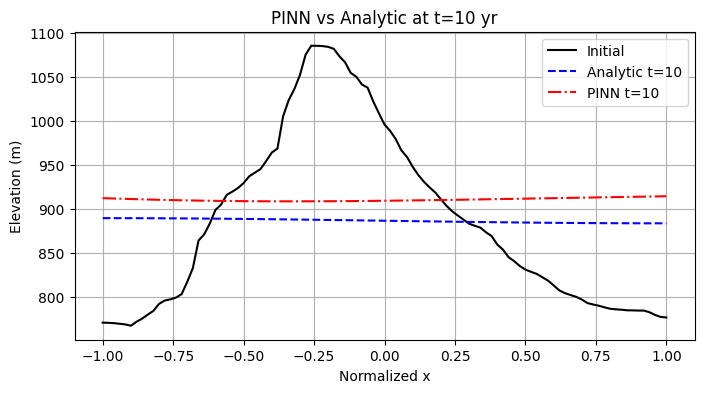

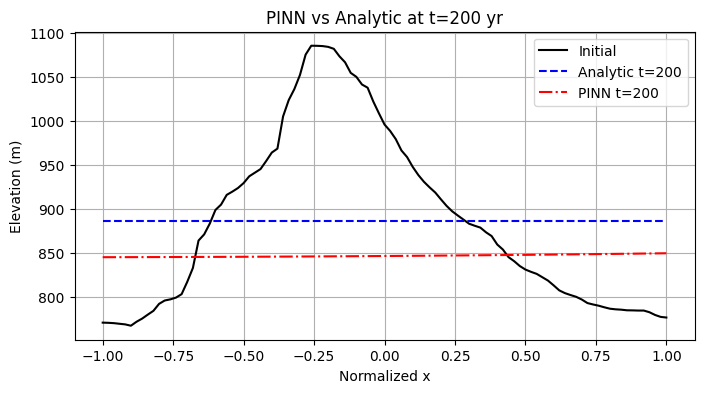

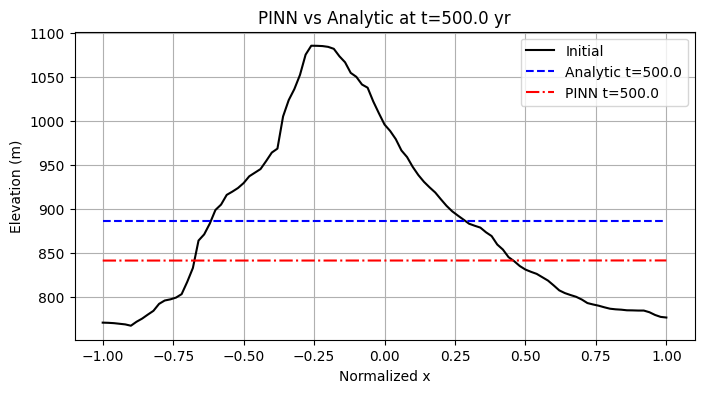

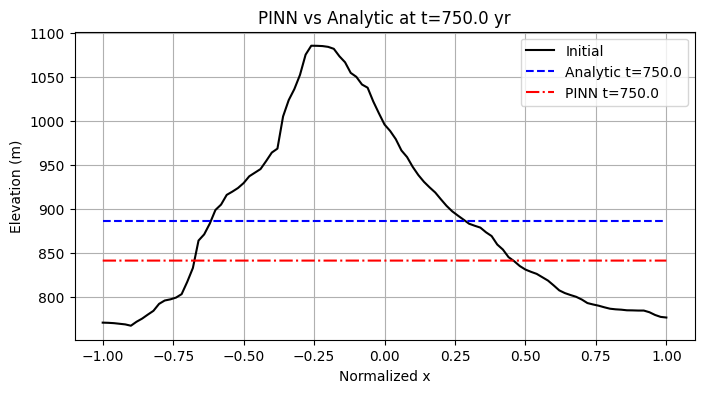

In [ ]:
for t_val in [10,200,500.0, 750.0]:
    t_tensor = tf.ones_like(x) * t_val
    h_pred_norm = model(tf.concat([x, t_tensor], axis=1)).numpy().squeeze()
    h_pred = h_pred_norm * (alt_max - alt_min) + alt_min

    # Ground truth analytic
    h_true_norm = analytic_neumann(altitudes_norm, diffusivity, t_val, dx)
    h_true = h_true_norm * (alt_max - alt_min) + alt_min

    plt.figure(figsize=(8,4))
    plt.plot(x.flatten(), altitudes_norm*(alt_max-alt_min)+alt_min, 'k-', label='Initial')
    plt.plot(x.flatten(), h_true, 'b--', label=f'Analytic t={t_val}')
    plt.plot(x.flatten(), h_pred, 'r-.', label=f'PINN t={t_val}')
    plt.xlabel('Normalized x')
    plt.ylabel('Elevation (m)')
    plt.title(f'PINN vs Analytic at t={t_val} yr')
    plt.legend()
    plt.grid(True)
    plt.show()


<ipython-input-16-c5f10c4a3361>:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max(), limit=100)
<ipython-input-16-c5f10c4a3361>:20: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max(), limit=100)


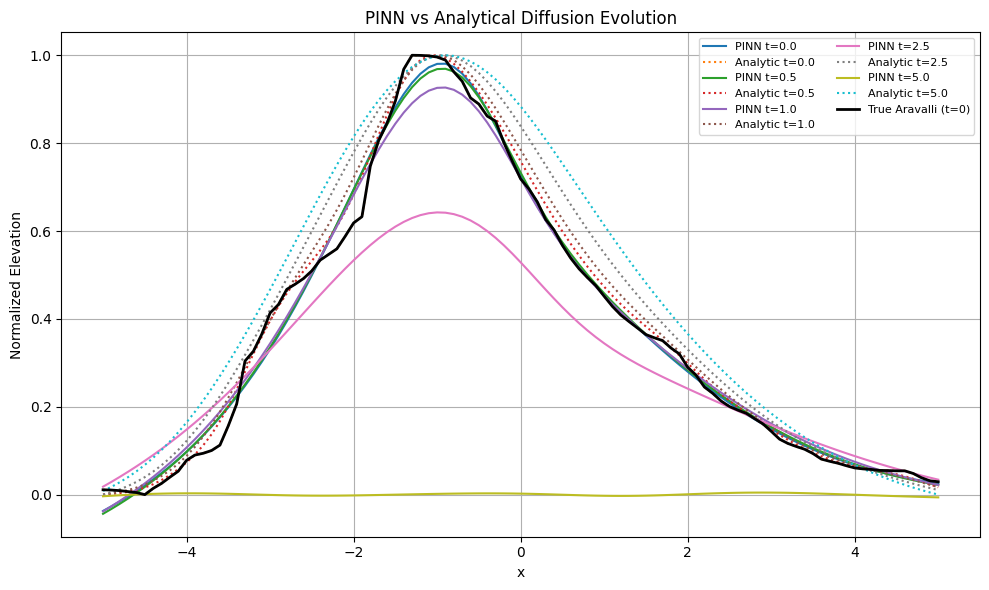

In [ ]:
from scipy.integrate import quad

# Define time steps
time_steps = [0.0, 0.5, 1.0, 2.5, 5.0]
x_vals = x_aravalli.squeeze()

plt.figure(figsize=(10, 6))

# --- Analytical solution for arbitrary h0(x) using convolution ---
def analytical_solution(x_vals, t, D=0.1):
    if t == 0:
        return h0_interp_np(x_vals)
    sol = []
    for x in x_vals:
        integrand = lambda xi: (
            h0_interp_np(xi)
            * np.exp(-(x - xi)**2 / (4 * D * t))
            / np.sqrt(4 * np.pi * D * t)
        )
        val, _ = quad(integrand, x_aravalli.min(), x_aravalli.max(), limit=100)
        sol.append(val)
    return np.array(sol)

# Interpolated initial profile
from scipy.interpolate import interp1d
h0_interp_np = interp1d(x_aravalli.flatten(), altitudes_norm, kind='cubic', fill_value="extrapolate")

# --- Plot PINN vs Analytical ---
for t in time_steps:
    # PINN prediction
    t_input = tf.ones_like(x_init) * t
    input_t = tf.concat([x_init, t_input], axis=1)
    h_pred_t = model(input_t).numpy().squeeze()
    plt.plot(x_vals, h_pred_t, '-', label=f'PINN t={t:.1f}')

    # Analytical solution
    h_analytic = analytical_solution(x_vals, t, D=0.1)
    h_analytic = (h_analytic - h_analytic.min()) / (h_analytic.max() - h_analytic.min() + 1e-8)
    plt.plot(x_vals, h_analytic, ':', label=f'Analytic t={t:.1f}')

# Initial profile
plt.plot(x_vals, altitudes_norm, 'k-', label='True Aravalli (t=0)', linewidth=2)

plt.xlabel("x")
plt.ylabel("Normalized Elevation")
plt.title("PINN vs Analytical Diffusion Evolution")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


### Hard Reinforcement of IC

Training the PINN...
Epoch 0: Loss = 0.194260
Epoch 500: Loss = 0.001527
Epoch 1000: Loss = 0.001044
Epoch 1500: Loss = 0.000929
Epoch 2000: Loss = 0.000876
Epoch 2500: Loss = 0.000845
Epoch 3000: Loss = 0.000820
Epoch 3500: Loss = 0.000798
Epoch 4000: Loss = 0.000778
Epoch 4500: Loss = 0.000747


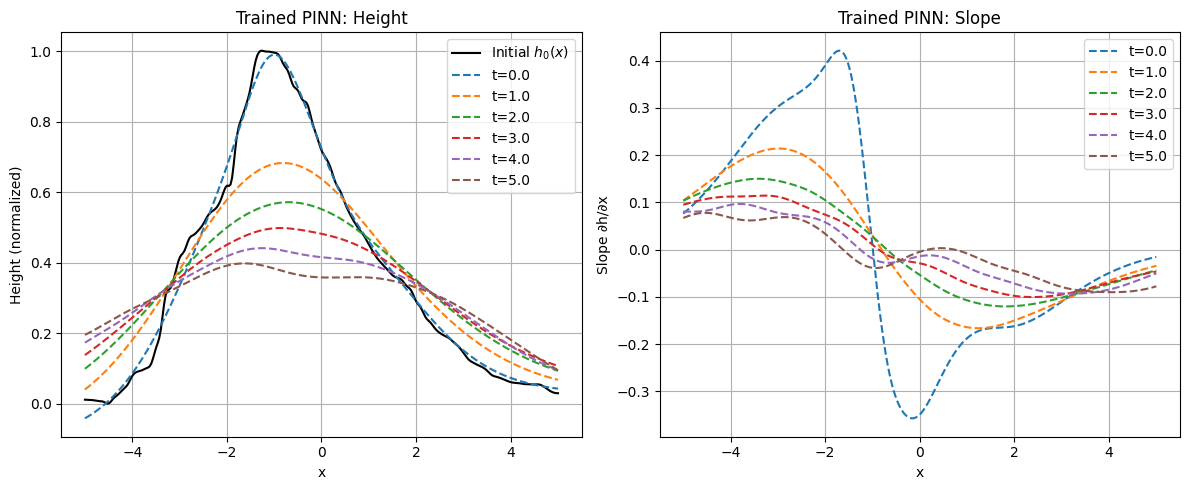

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- 1. Load and Normalize Aravalli Data ---
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')

altitudes = data["altitude (m)"].values.astype(np.float32)
altitudes_norm = (altitudes - np.min(altitudes)) / (np.max(altitudes) - np.min(altitudes))

x_aravalli = np.linspace(-5, 5, len(altitudes_norm)).astype(np.float32)
x_data = x_aravalli
h_data_normalized = altitudes_norm
h0_interp_np = interp1d(x_data, h_data_normalized, kind='cubic', fill_value="extrapolate")

# --- 2. Define the Neural Network ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- 3. Define Loss Function: Physics + Initial Condition ---
def pinn_loss(model, x_phys, t_phys, x0, h0, D=1.0):
    x_phys.requires_grad_(True)
    t_phys.requires_grad_(True)

    xt_phys = torch.cat((x_phys, t_phys), dim=1)
    h_pred = model(xt_phys)

    h_t = torch.autograd.grad(h_pred, t_phys, grad_outputs=torch.ones_like(h_pred), create_graph=True)[0]
    h_x = torch.autograd.grad(h_pred, x_phys, grad_outputs=torch.ones_like(h_pred), create_graph=True)[0]
    h_xx = torch.autograd.grad(h_x, x_phys, grad_outputs=torch.ones_like(h_x), create_graph=True)[0]

    physics_loss = torch.mean((h_t - D * h_xx) ** 2)

    t0 = torch.zeros_like(x0)
    xt0 = torch.cat((x0, t0), dim=1)
    h0_pred = model(xt0)
    ic_loss = torch.mean((h0_pred - h0) ** 2)

    return physics_loss + ic_loss

# --- 4. Data Generation ---
def generate_data(N_phys=10000, N_ic=200, x_range=(-5, 5), t_range=(0, 2)):
    # Physics collocation points
    x_phys = torch.rand((N_phys, 1)) * (x_range[1] - x_range[0]) + x_range[0]
    t_phys = torch.rand((N_phys, 1)) * (t_range[1] - t_range[0]) + t_range[0]

    # Initial condition points
    x0 = torch.linspace(x_range[0], x_range[1], N_ic).view(-1, 1)
    h0_vals = torch.tensor(h0_interp_np(x0.numpy().flatten()), dtype=torch.float32).view(-1, 1)

    return x_phys, t_phys, x0, h0_vals

# --- 5. Training ---
def train(model, x_phys, t_phys, x0, h0, epochs=5000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pinn_loss(model, x_phys, t_phys, x0, h0)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# --- 6. Plotting Function ---
def plot_height_and_slope(model, x_vals, times, title_prefix="Prediction"):
    model.eval()
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).view(-1, 1)

    plt.figure(figsize=(12, 5))

    # Height plot
    plt.subplot(1, 2, 1)
    h_true = h0_interp_np(x_vals)
    plt.plot(x_vals, h_true, 'k-', label="Initial $h_0(x)$")

    for t_val in times:
        t_tensor = torch.full_like(x_tensor, t_val)
        with torch.no_grad():
            h_pred = model(torch.cat((x_tensor, t_tensor), dim=1)).numpy().flatten()
        plt.plot(x_vals, h_pred, '--', label=f"t={t_val}")

    plt.xlabel("x")
    plt.ylabel("Height (normalized)")
    plt.title(f"{title_prefix}: Height")
    plt.legend()
    plt.grid(True)

    # Slope plot
    plt.subplot(1, 2, 2)
    for t_val in times:
        t_tensor = torch.full_like(x_tensor, t_val)
        x_tensor.requires_grad_(True)
        h_pred = model(torch.cat((x_tensor, t_tensor), dim=1))
        h_x = torch.autograd.grad(h_pred, x_tensor, torch.ones_like(h_pred), create_graph=True)[0]
        slope = h_x.detach().numpy().flatten()
        plt.plot(x_vals, slope, '--', label=f"t={t_val}")

    plt.xlabel("x")
    plt.ylabel("Slope ∂h/∂x")
    plt.title(f"{title_prefix}: Slope")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 7. Full Execution ---
model = Net()
x_phys, t_phys, x0, h0 = generate_data()
print("Training the PINN...")
train(model, x_phys, t_phys, x0, h0, epochs=5000)

# Visualize
x_vals = np.linspace(-5, 5, 300)
times_to_plot = np.linspace(0, 5, 6)
plot_height_and_slope(model, x_vals, times_to_plot, title_prefix="Trained PINN")


<ipython-input-11-056df05aa926>:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, xi_min, xi_max)


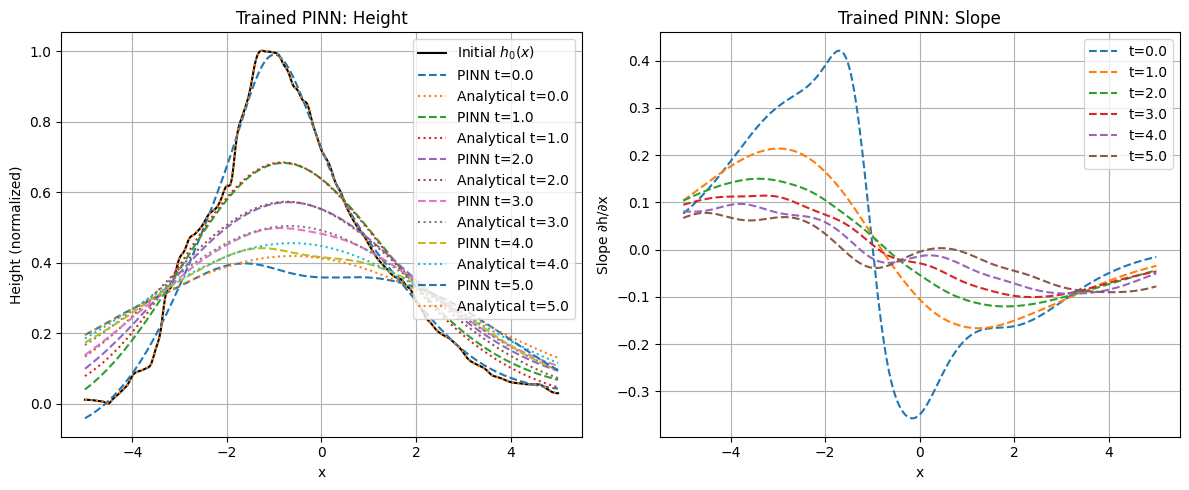

In [ ]:
from scipy.integrate import quad

def gaussian_kernel(x, xi, t, D=1.0):
    return np.exp(-(x - xi) ** 2 / (4 * D * t)) / np.sqrt(4 * np.pi * D * t)

def analytical_solution(x_vals, t, h0_func, D=1.0, xi_min=-5, xi_max=5):
    if t == 0:
        return h0_func(x_vals)
    sol = []
    for x in x_vals:
        integrand = lambda xi: h0_func(xi) * np.exp(-(x - xi) ** 2 / (4 * D * t)) / np.sqrt(4 * np.pi * D * t)
        val, _ = quad(integrand, xi_min, xi_max)
        sol.append(val)
    return np.array(sol)


# --- 6. Plotting Function ---
def plot_height_and_slope(model, x_vals, times, title_prefix="Prediction"):
    model.eval()
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).view(-1, 1)

    plt.figure(figsize=(12, 5))

    # Height plot
    plt.subplot(1, 2, 1)
    h_true = h0_interp_np(x_vals)
    plt.plot(x_vals, h_true, 'k-', label="Initial $h_0(x)$")

    for t_val in times:
        t_tensor = torch.full_like(x_tensor, t_val)
        with torch.no_grad():
            h_pred = model(torch.cat((x_tensor, t_tensor), dim=1)).numpy().flatten()
        plt.plot(x_vals, h_pred, '--', label=f"PINN t={t_val}")

        h_analytical = analytical_solution(x_vals, t_val, h0_interp_np)
        plt.plot(x_vals, h_analytical, ':', label=f"Analytical t={t_val}")

    plt.xlabel("x")
    plt.ylabel("Height (normalized)")
    plt.title(f"{title_prefix}: Height")
    plt.legend()
    plt.grid(True)

    # Slope plot
    plt.subplot(1, 2, 2)
    for t_val in times:
        t_tensor = torch.full_like(x_tensor, t_val)
        x_tensor.requires_grad_(True)
        h_pred = model(torch.cat((x_tensor, t_tensor), dim=1))
        h_x = torch.autograd.grad(h_pred, x_tensor, torch.ones_like(h_pred), create_graph=True)[0]
        slope = h_x.detach().numpy().flatten()
        plt.plot(x_vals, slope, '--', label=f"t={t_val}")

    plt.xlabel("x")
    plt.ylabel("Slope ∂h/∂x")
    plt.title(f"{title_prefix}: Slope")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize
x_vals = np.linspace(-5, 5, 300)
times_to_plot = np.linspace(0, 3, 3)
plot_height_and_slope(model, x_vals, times_to_plot, title_prefix="Trained PINN")


### Meta PiNN

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Load Aravalli Data ---
def load_aravalli_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
    data = [line.strip().split('\t') for line in lines if line.strip()]
    altitudes = [float(row[3]) for row in data]
    return np.array(altitudes)

altitudes = load_aravalli_data("/content/Aravalli range_1.txt")
altitudes = (altitudes - np.min(altitudes)) / (np.max(altitudes) - np.min(altitudes))
x_aravalli = np.linspace(-5, 5, len(altitudes)).reshape(-1, 1).astype(np.float32)
h_aravalli = altitudes.reshape(-1, 1).astype(np.float32)

x_aravalli_tf = tf.convert_to_tensor(x_aravalli)
h_aravalli_tf = tf.convert_to_tensor(h_aravalli)

# --- Synthetic Data Generator ---
data_points = 256
num_tasks = 50

def generate_synthetic_hill(task_id):
    x = np.linspace(-5, 5, data_points).reshape(-1, 1).astype(np.float32)
    if task_id % 3 == 0:
        h = np.exp(-((x - np.random.uniform(-2, 2))**2) / np.random.uniform(0.5, 2))
    elif task_id % 3 == 1:
        h = 0.5 * np.sin(np.pi * x) + 0.5
    else:
        h = 1 - (x**2) / 25 + 0.05 * np.random.randn(*x.shape)
    return x, h.astype(np.float32)

# --- Model Definition ---
def create_pinn_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

# --- Loss Function ---
def compute_loss(model, x_init, h_init, x_colloc, t_colloc, D=0.1):
    t0 = tf.zeros_like(x_init)
    inputs_init = tf.concat([x_init, t0], axis=1)
    h_pred_init = model(inputs_init)
    loss_ic = tf.reduce_mean(tf.square(h_pred_init - h_init))

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_colloc)
        tape2.watch(t_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_colloc)
            tape1.watch(t_colloc)
            inputs_colloc = tf.concat([x_colloc, t_colloc], axis=1)
            h_pred_colloc = model(inputs_colloc)
        h_x = tape1.gradient(h_pred_colloc, x_colloc)
        h_t = tape1.gradient(h_pred_colloc, t_colloc)
    h_xx = tape2.gradient(h_x, x_colloc)
    del tape1, tape2

    pde_residual = h_t - D * h_xx
    loss_pde = tf.reduce_mean(tf.square(pde_residual))
    total_loss = loss_ic + loss_pde
    return total_loss, loss_ic, loss_pde

# --- Meta-Training ---
def meta_train(meta_model, epochs=100, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        total_loss = 0
        for task_id in range(num_tasks):
            x_init_np, h_init_np = generate_synthetic_hill(task_id)
            x_init = tf.convert_to_tensor(x_init_np)
            h_init = tf.convert_to_tensor(h_init_np)
            x_colloc = tf.random.uniform((1000, 1), -5, 5)
            t_colloc = tf.random.uniform((1000, 1), 0, 1)

            with tf.GradientTape() as tape:
                total_loss_val, _, _ = compute_loss(meta_model, x_init, h_init, x_colloc, t_colloc)
            grads = tape.gradient(total_loss_val, meta_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, meta_model.trainable_variables))
            total_loss += total_loss_val.numpy()

        if epoch % 100 == 0:
            print(f"Meta Epoch {epoch}: Avg Task Loss = {total_loss / num_tasks:.6f}")

meta_model = create_pinn_model()
meta_train(meta_model)

# --- Fine-Tuning on Aravalli ---
def fine_tune_on_aravalli(model, x_aravalli_tf, h_aravalli_tf, fine_tune_steps=1000, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    D = 0.1
    for step in range(fine_tune_steps):
        with tf.GradientTape() as tape:
            x_colloc = tf.random.uniform((1000, 1), -5, 5)
            t_colloc = tf.random.uniform((1000, 1), 0, 1)
            total_loss, loss_ic, loss_pde = compute_loss(
                model,
                x_aravalli_tf, h_aravalli_tf,
                x_colloc, t_colloc,
                D
            )
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss.numpy():.6f}, IC Loss = {loss_ic.numpy():.6f}, PDE Loss = {loss_pde.numpy():.6f}")

fine_tune_on_aravalli(meta_model, x_aravalli_tf, h_aravalli_tf)

# --- Predict and Plot ---
t_steps = [0.0, 0.5, 1.0]
plt.figure(figsize=(10, 6))
for t_val in t_steps:
    t_input = tf.ones_like(x_aravalli_tf) * t_val
    input_t = tf.concat([x_aravalli_tf, t_input], axis=1)
    h_pred = meta_model(input_t).numpy().squeeze()
    plt.plot(h_pred, label=f'Predicted h(x, t={t_val})')

plt.plot(h_aravalli_tf.numpy().squeeze(), '--', label='True Aravalli h(x, 0)', color='black')
plt.xlabel('Point Index')
plt.ylabel('Elevation')
plt.title('Aravalli Evolution using Meta-PINN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Meta Epoch 0: Avg Task Loss = 0.175144


KeyboardInterrupt: 

### FnO

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# --- 1. Parameters for Synthetic Data Generation ---
N_profiles = 200       # number of distinct hills
grid_size = 256        # number of spatial points
x_min, x_max = -5, 5   # spatial domain
D = 0.1                # diffusion coefficient

# Time steps at which to generate solutions
time_steps = np.linspace(0, 2.0, 5)  # e.g., t = 0, 0.5, 1.0, 1.5, 2.0

# Spatial grid
x = np.linspace(x_min, x_max, grid_size)
dx = x[1] - x[0]  # uniform spacing

# Prepare containers
data = []

for i in range(N_profiles):
    # --- Generate initial hillslope profile h0(x) ---
    shift = np.random.uniform(-2, 2)
    width = np.random.uniform(1.0, 3.0)
    h0 = np.exp(-((x - shift) ** 2) / (2 * width ** 2))
    h0 += 0.1 * np.sin(2 * np.pi * x / np.random.uniform(4, 8))
    h0 = np.clip(h0, 0, None)
    h0 = (h0 - h0.min()) / (h0.max() - h0.min() + 1e-8)

    for t in time_steps:
        if t == 0:
            h_t = h0.copy()
        else:
            # Convolve using Gaussian filter with appropriate sigma
            sigma = np.sqrt(2 * D * t) / dx  # convert physical sigma to grid sigma
            h_t = gaussian_filter1d(h0, sigma=sigma, mode='constant')
        h_t = (h_t - h_t.min()) / (h_t.max() - h_t.min() + 1e-8)
        data.append({
            'h0': h0.astype(np.float32),
            't': float(t),
            'h_t': h_t.astype(np.float32)
        })

# --- Save as Numpy Arrays ---
df = pd.DataFrame([{ 't': entry['t'] } for entry in data])
h0_array = np.stack([entry['h0'] for entry in data])  # (N, grid_size)
h_t_array = np.stack([entry['h_t'] for entry in data])
np.save('h0_profiles.npy', h0_array)
np.save('h_t_profiles.npy', h_t_array)
df.to_csv('time_steps.csv', index=False)

print("✅ Fast synthetic FNO dataset generated:")
print(f"  Samples: {len(data)}")
print(f"  Grid size: {grid_size}")
print(f"  Time steps: {time_steps}")


✅ Fast synthetic FNO dataset generated:
  Samples: 1000
  Grid size: 256
  Time steps: [0.  0.5 1.  1.5 2. ]


In [ ]:
# after defining time_steps = np.linspace(0,2.0,5)
np.savetxt('time_labels.csv', time_steps, delimiter=',')


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- 1. Load Synthetic Dataset ---
h0 = np.load("h0_profiles.npy")         # Shape: [N, 256]
ht = np.load("h_t_profiles.npy")        # Shape: [N, 5, 256]
time_steps = np.loadtxt("time_labels.csv", delimiter=',')  # Shape: [5]

h0_tensor = torch.tensor(h0, dtype=torch.float32)          # [N, 256]
ht_tensor = torch.tensor(ht, dtype=torch.float32)          # [N, 5, 256]

N = h0_tensor.shape[0]
n_grid = h0_tensor.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # number of Fourier modes to keep
        # complex weights: [in_chan, out_chan, modes]
        self.weights = nn.Parameter(
            torch.randn(in_channels, out_channels, self.modes, dtype=torch.cfloat) * (1 / (in_channels * out_channels))
        )

    def compl_mul1d(self, input_ft, weights):
        # input_ft: [B, in_channels, modes]
        # weights:  [in_channels, out_channels, modes]
        # output:   [B, out_channels, modes]
        # sum over in_channels
        return torch.einsum("bim,iom->bom", input_ft, weights)

    def forward(self, x):
        # x: [B, in_channels, n_grid]
        batchsize = x.size(0)
        # take Fourier transform along last axis
        x_ft = torch.fft.rfft(x, dim=-1)  # [B, in_channels, n_modes]
        # prepare output in Fourier domain
        n_modes = x_ft.size(-1)
        out_ft = torch.zeros(batchsize, self.out_channels, n_modes, dtype=torch.cfloat, device=x.device)
        # multiply only the first self.modes modes
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        # return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x


# --- 3. FNO1D Architecture ---
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(2, self.width)  # input: (h0, t) → width channels

        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x, t):
        batchsize = x.shape[0]
        t = t.view(batchsize, 1).repeat(1, x.shape[1])
        xt = torch.stack([x, t], dim=2)  # [B, n_grid, 2]
        x = self.fc0(xt)  # [B, n_grid, width]
        x = x.permute(0, 2, 1)  # [B, width, n_grid]

        x1 = self.conv1(x) + self.w1(x)
        x2 = self.conv2(F.gelu(x1)) + self.w2(x1)
        x3 = self.conv3(F.gelu(x2)) + self.w3(x2)

        x = F.gelu(x3)
        x = x.permute(0, 2, 1)  # [B, n_grid, width]
        x = F.gelu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)  # [B, n_grid]
        return x

# --- 4. Prepare Training Data ---
t_target_idx = 3  # e.g., predict h(x, t=target)
x_train = h0_tensor.to(device)
y_train = ht_tensor[:, t_target_idx].to(device)  # [N, 256]
t_val = time_steps[t_target_idx]
t_train = torch.ones(N, device=device) * t_val

# --- 5. Train FNO ---
model = FNO1D(modes=16, width=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(x_train, t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# --- 6. Test on Aravalli ---
from scipy.interpolate import interp1d
aravalli_raw = pd.read_csv("Aravalli range_1.txt", sep='\t')["altitude (m)"].values
aravalli_norm = (aravalli_raw - aravalli_raw.min()) / (aravalli_raw.max() - aravalli_raw.min())
aravalli_interp = interp1d(np.linspace(-5, 5, len(aravalli_norm)), aravalli_norm, kind='cubic')
aravalli_grid = np.linspace(-5, 5, x_train.shape[1])
aravalli_profile = aravalli_interp(aravalli_grid)

model.eval()
x_aravalli = torch.tensor(aravalli_profile, dtype=torch.float32).unsqueeze(0).to(device)
t_aravalli = torch.tensor([t_val], dtype=torch.float32).to(device)
with torch.no_grad():
    pred_aravalli = model(x_aravalli, t_aravalli).cpu().numpy().squeeze()

# --- 7. Plot Aravalli Prediction ---
plt.figure(figsize=(10, 5))
plt.plot(aravalli_grid, aravalli_profile, 'k--', label='Initial Aravalli h(x, 0)')
plt.plot(aravalli_grid, pred_aravalli, 'r-', label=f'FNO Prediction at t={t_val:.1f}')
plt.xlabel("x")
plt.ylabel("Normalized Elevation")
plt.title("FNO Prediction for Aravalli Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (256) must match the size of tensor b (1000) at non-singleton dimension 1

### PINN vs FNO

EP    0 | L=7.515e-01, IC=3.239e-01, PDE=2.087e-01, BC=4.068e+00
EP  200 | L=6.744e-03, IC=5.282e-03, PDE=1.363e-02, BC=9.868e-04
EP  400 | L=3.128e-03, IC=1.998e-03, PDE=1.053e-02, BC=7.749e-04
EP  600 | L=2.169e-03, IC=1.184e-03, PDE=9.280e-03, BC=5.723e-04
EP  800 | L=1.994e-03, IC=1.070e-03, PDE=8.731e-03, BC=5.099e-04
Epoch 1/200
10/10 - 8s - 784ms/step - loss: 0.1248 - mse: 0.1248 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 2/200
10/10 - 2s - 183ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 3/200
10/10 - 1s - 55ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/200
10/10 - 1s - 84ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/200
10/10 - 1s - 133ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 9.7297e-04 - val_mse: 9.7297e-04
Epoch 6/200
10/10 - 1s - 92ms/step - loss: 6.4587e-04 - mse: 6.4587e-04 - val_loss: 3.4611e-04 - val_mse: 3.4611e-04
Epoch 7/200
10/10 - 1s - 58ms/step - loss:

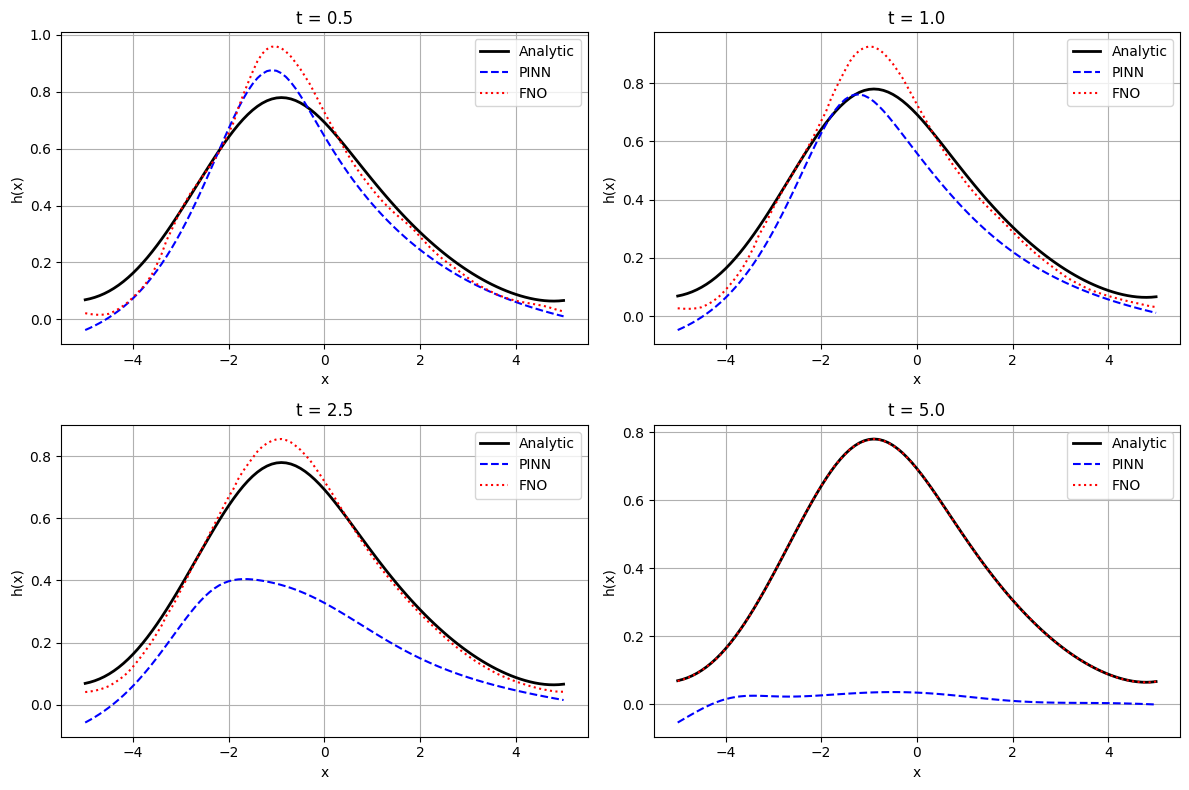

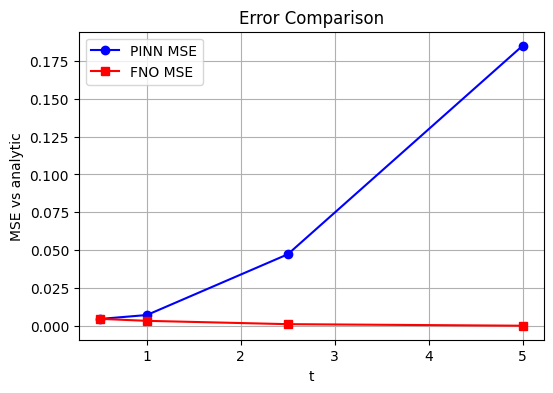

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Load & normalize Aravalli data
# -----------------------------------------------------------------------------
filename = "Aravalli range_1.txt"   # adjust path as needed
data = pd.read_csv(filename, sep='\t')
altitudes    = data["altitude (m)"].values.astype(np.float32)
altitudes_nm = (altitudes - altitudes.min())/(altitudes.max()-altitudes.min())
n_x          = altitudes_nm.shape[0]

# spatial grid
x_ar       = np.linspace(-5, 5, n_x).reshape(-1,1).astype(np.float32)
x_init     = tf.convert_to_tensor(x_ar, dtype=tf.float32)
h_init     = tf.convert_to_tensor(altitudes_nm.reshape(-1,1), dtype=tf.float32)
dx         = x_ar[1,0] - x_ar[0,0]

# -----------------------------------------------------------------------------
# 2) Define & train your PINN for hill-slope diffusion
# -----------------------------------------------------------------------------
# hyperparams
D      = 0.1
T_inf  = 5.0
λ_ic   = 1.0
λ_pde  = 0.1
λ_bc   = 0.1

# collocation & BC sample points
num_colloc = 10000
num_bc     = 1000
x_colloc   = tf.random.uniform((num_colloc,1), -5,5)
t_colloc   = tf.random.uniform((num_colloc,1),  0, T_inf)
x_bc       = tf.random.uniform((num_bc,1),      -5,5)

def create_pinn():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer((2,)),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

pinn = create_pinn()
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def pinn_loss():
    # Initial condition loss
    t0   = tf.zeros_like(x_init)
    h0_p = pinn(tf.concat([x_init, t0], axis=1))
    l_ic = tf.reduce_mean((h0_p - h_init)**2)

    # PDE residual loss: use persistent tape for inner gradients
    with tf.GradientTape() as tape2:
        tape2.watch(x_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_colloc)
            tape1.watch(t_colloc)
            h_c = pinn(tf.concat([x_colloc, t_colloc], axis=1))
        # first derivatives
        h_x = tape1.gradient(h_c, x_colloc)
        h_t = tape1.gradient(h_c, t_colloc)
        # second derivative
        h_xx = tape2.gradient(h_x, x_colloc)
        # cleanup
        del tape1

    l_pde = tf.reduce_mean((h_t - D * h_xx)**2)

    # Boundary condition loss at t = T_inf
    t_inf = tf.ones_like(x_bc) * T_inf
    h_inf = pinn(tf.concat([x_bc, t_inf], axis=1))
    l_bc  = tf.reduce_mean(h_inf**2)

    total = λ_ic * l_ic + λ_pde * l_pde + λ_bc * l_bc
    return total, l_ic, l_pde, l_bc

# training loop
epochs = 1000
for ep in range(epochs):
    with tf.GradientTape() as tape:
        L, l_ic, l_pde, l_bc = pinn_loss()
    grads = tape.gradient(L, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    if ep % 200 == 0:
        print(f"EP {ep:4d} | L={L:.3e}, IC={l_ic:.3e}, PDE={l_pde:.3e}, BC={l_bc:.3e}")

# -----------------------------------------------------------------------------
# 3) Analytic diffusion solution via FFT convolution
# -----------------------------------------------------------------------------
def analytic_fft(h0, dx, t, D=0.1):
    """Compute G_t * h0 via FFT for constant-D diffusion on a uniform grid."""
    if t == 0.0:
        return h0
    h0_hat = np.fft.rfft(h0)
    k      = np.fft.rfftfreq(h0.size, d=dx)
    ω2     = (2*np.pi*k)**2
    kernel = np.exp(-D * t * ω2)
    return np.fft.irfft(h0_hat * kernel, n=h0.size)

# -----------------------------------------------------------------------------
# 4) Build the 1D FNO class
# -----------------------------------------------------------------------------
class SpectralConv1d(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c, modes):
        super().__init__()
        self.in_c, self.out_c, self.modes = in_c, out_c, modes
        self.w = self.add_weight(
            shape=(in_c, out_c, modes),
            initializer="glorot_uniform", trainable=True
        )
    def call(self, x):
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        # FFT in channel-first layout
        x_ft = tf.signal.rfft(tf.transpose(x, [0,2,1]))
        w_c = tf.complex(self.w, 0.0)
        # apply low modes
        out_ft = tf.concat([
            tf.einsum('bim, iom->bom', x_ft[:,:,:self.modes], w_c),
            tf.zeros((B, self.out_c, tf.shape(x_ft)[2]-self.modes), dtype=tf.complex64)
        ], axis=2)
        x_out = tf.signal.irfft(out_ft, fft_length=[N])
        return tf.transpose(x_out, [0,2,1])

class FNO1d(tf.keras.Model):
    def __init__(self, modes, width, depth=4):
        super().__init__()
        self.fc0  = tf.keras.layers.Dense(width)
        self.spec = [SpectralConv1d(width, width, modes) for _ in range(depth)]
        self.pw   = [tf.keras.layers.Conv1D(width, 1) for _ in range(depth)]
        self.act  = tf.keras.layers.Activation('gelu')
        self.fc1  = tf.keras.layers.Dense(128, activation='gelu')
        self.fc2  = tf.keras.layers.Dense(1)
    def call(self, x):
        x = self.fc0(x)
        for s, p in zip(self.spec, self.pw):
            x = self.act(s(x) + p(x))
        x = self.fc1(x)
        return self.fc2(x)

# -----------------------------------------------------------------------------
# 5) Generate analytic training data for FNO
# -----------------------------------------------------------------------------
times = np.linspace(0.0, 5.0, 100, dtype=np.float32)
X_data, Y_data = [], []
for t in times:
    h_an = analytic_fft(altitudes_nm, dx, float(t), D)
    inp  = np.stack([altitudes_nm, np.ones_like(altitudes_nm)*t], axis=1)
    X_data.append(inp)
    Y_data.append(h_an.reshape(-1,1))
X_data = np.stack(X_data, axis=0)
Y_data = np.stack(Y_data, axis=0)

perm = np.random.permutation(len(times))
tr, vl = perm[:80], perm[80:]
X_tr, Y_tr = X_data[tr], Y_data[tr]
X_vl, Y_vl = X_data[vl], Y_data[vl]

# -----------------------------------------------------------------------------
# 6) Train FNO on analytic data
# -----------------------------------------------------------------------------
fno = FNO1d(modes=16, width=64, depth=4)
fno.compile('adam', loss='mse', metrics=['mse'])
fno.fit(X_tr, Y_tr, validation_data=(X_vl, Y_vl), epochs=200, batch_size=8, verbose=2)

# -----------------------------------------------------------------------------
# 7) Compare at test times & plot
# -----------------------------------------------------------------------------
test_ts = [0.5, 1.0, 2.5, 5.0]
errors = {'t': [], 'mse_pinn': [], 'mse_fno': []}

plt.figure(figsize=(12, 8))
for i, t in enumerate(test_ts):
    # analytic\ n    h_an   = analytic_fft(altitudes_nm, dx, t, D)
    # PINN
    xt     = tf.concat([x_init, tf.ones_like(x_init)*t], axis=1)
    h_pinn = pinn(xt).numpy().squeeze()
    # FNO
    inp    = np.stack([altitudes_nm, np.ones_like(altitudes_nm)*t], axis=1)[None,...]
    h_fno  = fno(inp).numpy().squeeze()

    mse_p = np.mean((h_pinn - h_an)**2)
    mse_f = np.mean((h_fno  - h_an)**2)
    errors['t'].append(t)
    errors['mse_pinn'].append(mse_p)
    errors['mse_fno'].append(mse_f)

    plt.subplot(2,2,i+1)
    plt.plot(x_ar, h_an,   'k-', lw=2, label='Analytic')
    plt.plot(x_ar, h_pinn, 'b--',      label='PINN')
    plt.plot(x_ar, h_fno,  'r:',       label='FNO')
    plt.title(f't = {t:.1f}')
    plt.xlabel('x'); plt.ylabel('h(x)')
    plt.legend(); plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(errors['t'], errors['mse_pinn'], 'b-o', label='PINN MSE')
plt.plot(errors['t'], errors['mse_fno'],  'r-s', label='FNO MSE')
plt.xlabel('t'); plt.ylabel('MSE vs analytic')
plt.legend(); plt.grid(); plt.title('Error Comparison')
plt.show()


Epoch 1/200
10/10 - 19s - 2s/step - loss: 0.1019 - mse: 0.1019 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 2/200
10/10 - 2s - 175ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 3/200
10/10 - 1s - 103ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/200
10/10 - 1s - 124ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 9.3295e-04 - val_mse: 9.3295e-04
Epoch 5/200
10/10 - 1s - 72ms/step - loss: 8.2192e-04 - mse: 8.2192e-04 - val_loss: 2.0630e-04 - val_mse: 2.0630e-04
Epoch 6/200
10/10 - 1s - 109ms/step - loss: 3.2978e-04 - mse: 3.2978e-04 - val_loss: 2.5043e-04 - val_mse: 2.5043e-04
Epoch 7/200
10/10 - 1s - 61ms/step - loss: 1.9945e-04 - mse: 1.9945e-04 - val_loss: 1.4060e-04 - val_mse: 1.4060e-04
Epoch 8/200
10/10 - 1s - 55ms/step - loss: 1.3578e-04 - mse: 1.3578e-04 - val_loss: 6.5246e-05 - val_mse: 6.5246e-05
Epoch 9/200
10/10 - 1s - 69ms/step - loss: 8.5955e-05 - mse: 8.5955e-05 - val_loss: 5.6601e-05 - val_mse: 5.6601e-05


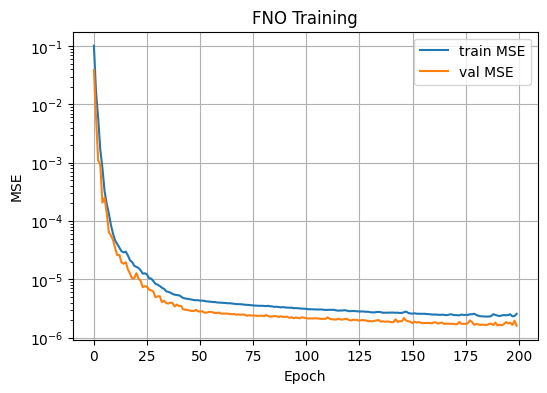

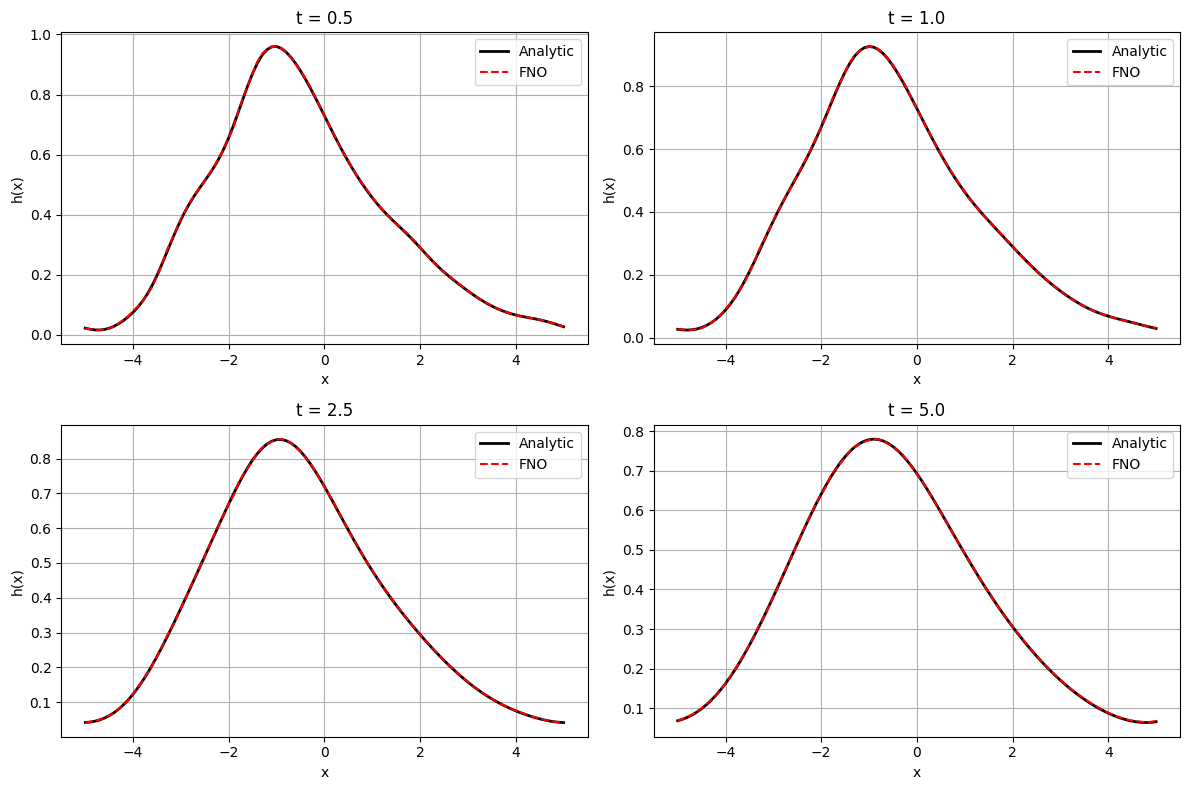

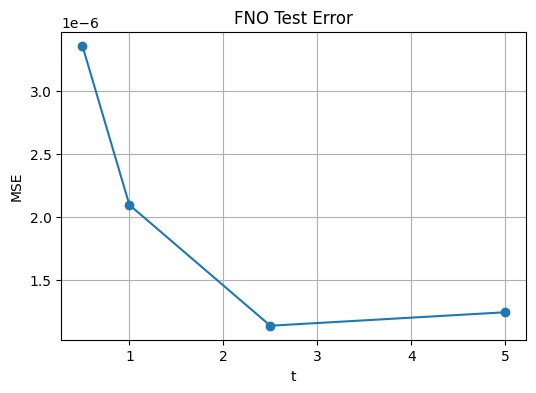

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Load & normalize Aravalli data
# -----------------------------------------------------------------------------
filename    = "Aravalli range_1.txt"   # adjust path as needed
data        = pd.read_csv(filename, sep='\t')
h0          = data["altitude (m)"].values.astype(np.float32)
h0_nm       = (h0 - h0.min())/(h0.max() - h0.min())
n_x         = h0_nm.shape[0]

# spatial grid
x_ar   = np.linspace(-5, 5, n_x, dtype=np.float32)[:,None]
dx     = x_ar[1,0] - x_ar[0,0]

# -----------------------------------------------------------------------------
# 2) Analytic diffusion via FFT convolution
# -----------------------------------------------------------------------------
def analytic_fft(h0, dx, t, D=0.1):
    if t == 0.0:
        return h0
    h0_hat = np.fft.rfft(h0)
    k      = np.fft.rfftfreq(h0.size, d=dx)
    ω2     = (2*np.pi*k)**2
    kernel = np.exp(-D * t * ω2)
    return np.fft.irfft(h0_hat * kernel, n=h0.size)

# -----------------------------------------------------------------------------
# 3) FNO architecture
# -----------------------------------------------------------------------------
class SpectralConv1d(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c, modes):
        super().__init__()
        self.w = self.add_weight(
            shape=(in_c, out_c, modes),
            initializer="glorot_uniform", trainable=True
        )
        self.modes = modes

    def call(self, x):
        # x: (B, N, C) → we want channel-first for FFT
        x_ft = tf.signal.rfft(tf.transpose(x, [0,2,1]))  # (B, C, Nfreq)
        w_c  = tf.complex(self.w, 0.0)
        # multiply only the first modes
        out_ft = tf.concat([
            tf.einsum('bim, iom->bom', x_ft[:,:,:self.modes], w_c),
            tf.zeros_like(x_ft[:,:,self.modes:])
        ], axis=-1)
        x_out = tf.signal.irfft(out_ft, fft_length=[tf.shape(x)[1]])
        return tf.transpose(x_out, [0,2,1])

class FNO1d(tf.keras.Model):
    def __init__(self, modes, width, depth=4):
        super().__init__()
        self.fc0  = tf.keras.layers.Dense(width)
        self.spec = [SpectralConv1d(width, width, modes) for _ in range(depth)]
        self.pw   = [tf.keras.layers.Conv1D(width, 1)     for _ in range(depth)]
        self.act  = tf.keras.layers.Activation('gelu')
        self.fc1  = tf.keras.layers.Dense(128, activation='gelu')
        self.fc2  = tf.keras.layers.Dense(1)

    def call(self, x):
        # x: (B, N, 2)  → spits out (B, N, 1)
        x = self.fc0(x)
        for s, p in zip(self.spec, self.pw):
            x = self.act(s(x) + p(x))
        x = self.fc1(x)
        return self.fc2(x)

# -----------------------------------------------------------------------------
# 4) Prepare train/val/test time splits
# -----------------------------------------------------------------------------
D         = 0.1
all_times = np.linspace(0.0, 5.0, 100, dtype=np.float32)

# hold‑out test times (never seen during train/val)
test_ts   = [0.5, 1.0, 2.5, 5.0]

# remove test_ts from the full grid (using a tiny tolerance)
train_val_times = np.array([
    t for t in all_times
    if not any(abs(t - t_test) < 1e-6 for t_test in test_ts)
], dtype=np.float32)

# now shuffle and split into 80% train, 20% val
perm    = np.random.permutation(len(train_val_times))
n_train = int(0.8 * len(train_val_times))
times_tr = train_val_times[perm[:n_train]]
times_vl = train_val_times[perm[n_train:]]

def make_dataset(times):
    X, Y = [], []
    for t in times:
        h_t = analytic_fft(h0_nm, dx, float(t), D)
        inp = np.stack([
            h0_nm,
            np.ones_like(h0_nm)*t
        ], axis=1)
        X.append(inp)
        Y.append(h_t.reshape(-1,1))
    X = np.stack(X, axis=0)  # (Nt, Nx, 2)
    Y = np.stack(Y, axis=0)  # (Nt, Nx, 1)
    return X, Y

X_tr, Y_tr = make_dataset(times_tr)
X_vl, Y_vl = make_dataset(times_vl)

# -----------------------------------------------------------------------------
# 5) Train the FNO
# -----------------------------------------------------------------------------
fno = FNO1d(modes=16, width=64, depth=4)
fno.compile('adam', loss='mse', metrics=['mse'])

history = fno.fit(
    X_tr, Y_tr,
    validation_data=(X_vl, Y_vl),
    epochs=200,
    batch_size=8,
    verbose=2
)

# -----------------------------------------------------------------------------
# 6) Plot train vs val loss
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],   label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('FNO Training')
plt.legend(); plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 7) Evaluate on held‑out test times and compare to analytic
# -----------------------------------------------------------------------------
errors = {'t': [], 'mse_fno': []}
plt.figure(figsize=(12,8))

for i, t in enumerate(test_ts):
    h_an   = analytic_fft(h0_nm, dx, t, D)
    inp    = np.stack([h0_nm, np.ones_like(h0_nm)*t], axis=1)[None,...]
    h_pred = fno(inp).numpy().squeeze()

    mse = np.mean((h_pred - h_an)**2)
    errors['t'].append(t)
    errors['mse_fno'].append(mse)

    ax = plt.subplot(2,2,i+1)
    ax.plot(x_ar, h_an,   'k-', lw=2, label='Analytic')
    ax.plot(x_ar, h_pred,'r--',      label='FNO')
    ax.set_title(f't = {t:.1f}'); ax.set_xlabel('x'); ax.set_ylabel('h(x)')
    ax.legend(); ax.grid()

plt.tight_layout()
plt.show()

# and error vs time
plt.figure(figsize=(6,4))
plt.plot(errors['t'], errors['mse_fno'], '-o')
plt.xlabel('t'); plt.ylabel('MSE'); plt.title('FNO Test Error')
plt.grid(); plt.show()


EP    0 | L=3.040e-01, IC=2.638e-01, PDE=1.950e-02, BC=3.819e-01
EP  200 | L=4.928e-03, IC=3.978e-03, PDE=8.847e-03, BC=6.468e-04
EP  400 | L=2.298e-03, IC=1.412e-03, PDE=8.426e-03, BC=4.278e-04
EP  600 | L=1.908e-03, IC=1.044e-03, PDE=8.273e-03, BC=3.685e-04
EP  800 | L=1.785e-03, IC=9.289e-04, PDE=8.200e-03, BC=3.608e-04
Epoch 1/200
10/10 - 10s - 1s/step - loss: 0.1095 - mse: 0.1095 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 2/200
10/10 - 3s - 282ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/200
10/10 - 3s - 349ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/200
10/10 - 4s - 414ms/step - loss: 9.9585e-04 - mse: 9.9585e-04 - val_loss: 1.8062e-04 - val_mse: 1.8062e-04
Epoch 5/200
10/10 - 3s - 253ms/step - loss: 2.7332e-04 - mse: 2.7332e-04 - val_loss: 2.6059e-04 - val_mse: 2.6059e-04
Epoch 6/200
10/10 - 3s - 268ms/step - loss: 1.3065e-04 - mse: 1.3065e-04 - val_loss: 9.9467e-05 - val_mse: 9.9467e-05
Epoch 7/200
10/10

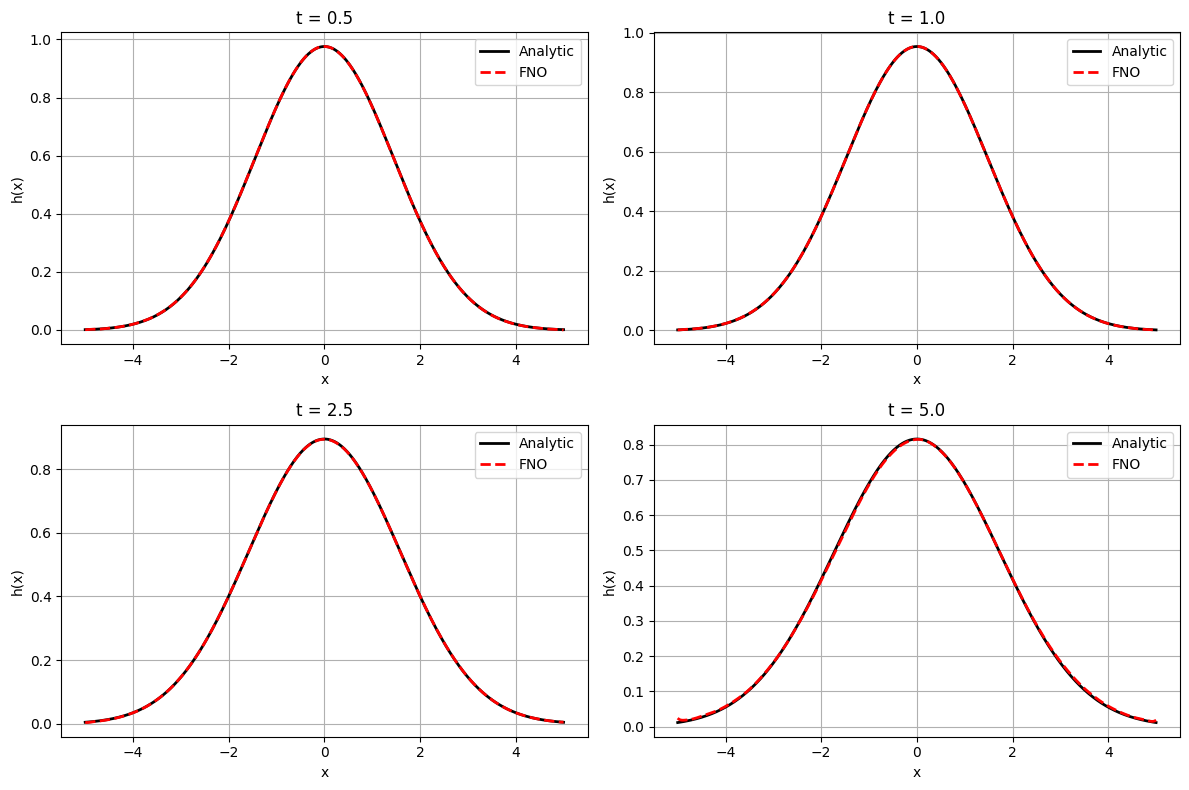

In [ ]:
# Complete and corrected code to compare PINN and FNO for diffusion of Aravalli shape

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
# ----------------------------------------------------------------------------
# 1) Load & normalize Aravalli data
# ----------------------------------------------------------------------------
filename = "Aravalli range_1.txt"  # Adjust as needed
data = pd.read_csv(filename, sep='\t')
altitudes = data["altitude (m)"].values.astype(np.float32)
altitudes_nm = (altitudes - altitudes.min()) / (altitudes.max() - altitudes.min())
n_x = altitudes_nm.shape[0]

x_ar = np.linspace(-5, 5, n_x).reshape(-1, 1).astype(np.float32)
x_init = tf.convert_to_tensor(x_ar, dtype=tf.float32)
h_init = tf.convert_to_tensor(altitudes_nm.reshape(-1, 1), dtype=tf.float32)
dx = x_ar[1, 0] - x_ar[0, 0]

# ----------------------------------------------------------------------------
# 2) PINN definition & training
# ----------------------------------------------------------------------------
D = 0.1
T_inf = 5.0
lambda_ic, lambda_pde, lambda_bc = 1.0, 0.1, 0.1

num_colloc, num_bc = 10000, 1000
x_colloc = tf.random.uniform((num_colloc, 1), -5, 5)
t_colloc = tf.random.uniform((num_colloc, 1), 0, T_inf)
x_bc = tf.random.uniform((num_bc, 1), -5, 5)

def create_pinn():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer((2,)),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

pinn = create_pinn()
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def pinn_loss():
    t0 = tf.zeros_like(x_init)
    h0_pred = pinn(tf.concat([x_init, t0], axis=1))
    l_ic = tf.reduce_mean((h0_pred - h_init)**2)

    with tf.GradientTape() as tape2:
        tape2.watch(x_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_colloc)
            tape1.watch(t_colloc)
            h_c = pinn(tf.concat([x_colloc, t_colloc], axis=1))
        h_x = tape1.gradient(h_c, x_colloc)
        h_t = tape1.gradient(h_c, t_colloc)
        h_xx = tape2.gradient(h_x, x_colloc)
        del tape1

    l_pde = tf.reduce_mean((h_t - D * h_xx)**2)

    t_inf = tf.ones_like(x_bc) * T_inf
    h_inf = pinn(tf.concat([x_bc, t_inf], axis=1))
    l_bc = tf.reduce_mean(h_inf**2)

    total_loss = lambda_ic * l_ic + lambda_pde * l_pde + lambda_bc * l_bc
    return total_loss, l_ic, l_pde, l_bc

for ep in range(1000):
    with tf.GradientTape() as tape:
        L, l_ic, l_pde, l_bc = pinn_loss()
    grads = tape.gradient(L, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    if ep % 200 == 0:
        print(f"EP {ep:4d} | L={L:.3e}, IC={l_ic:.3e}, PDE={l_pde:.3e}, BC={l_bc:.3e}")

# ----------------------------------------------------------------------------
# 3) Analytic solution via FFT
# ----------------------------------------------------------------------------
def analytic_fft(h0, dx, t, D=0.1):
    if t == 0.0:
        return h0
    h0_hat = np.fft.rfft(h0)
    k = np.fft.rfftfreq(h0.size, d=dx)
    omega2 = (2 * np.pi * k)**2
    kernel = np.exp(-D * t * omega2)
    return np.fft.irfft(h0_hat * kernel, n=h0.size)

# ----------------------------------------------------------------------------
# 4) FNO class
# ----------------------------------------------------------------------------
class SpectralConv1d(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c, modes):
        super().__init__()
        self.in_c, self.out_c, self.modes = in_c, out_c, modes
        self.w = self.add_weight(shape=(in_c, out_c, modes), initializer="glorot_uniform", trainable=True)

    def call(self, x):
        B, N = tf.shape(x)[0], tf.shape(x)[1]
        x_ft = tf.signal.rfft(tf.transpose(x, [0, 2, 1]))
        w_c = tf.complex(self.w, 0.0)
        out_ft = tf.concat([
            tf.einsum('bim, iom->bom', x_ft[:, :, :self.modes], w_c),
            tf.zeros((B, self.out_c, tf.shape(x_ft)[2] - self.modes), dtype=tf.complex64)
        ], axis=2)
        x_out = tf.signal.irfft(out_ft, fft_length=[N])
        return tf.transpose(x_out, [0, 2, 1])

class FNO1d(tf.keras.Model):
    def __init__(self, modes, width, depth=4):
        super().__init__()
        self.fc0 = tf.keras.layers.Dense(width)
        self.spec = [SpectralConv1d(width, width, modes) for _ in range(depth)]
        self.pw = [tf.keras.layers.Conv1D(width, 1) for _ in range(depth)]
        self.act = tf.keras.layers.Activation('gelu')
        self.fc1 = tf.keras.layers.Dense(128, activation='gelu')
        self.fc2 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.fc0(x)
        for s, p in zip(self.spec, self.pw):
            x = self.act(s(x) + p(x))
        x = self.fc1(x)
        return self.fc2(x)



# ----------------------------------------------------------------------------
# 1) Load initial condition from file (synthetic hill)
# ----------------------------------------------------------------------------
df = pd.read_csv("/content/synthetic_hill_data.csv")
x_raw = df['x'].values.astype(np.float32)
h_raw = df['h'].values.astype(np.float32)

# Normalize
h_nm = (h_raw - h_raw.min()) / (h_raw.max() - h_raw.min())
x_vals = np.linspace(x_raw.min(), x_raw.max(), len(x_raw)).astype(np.float32)

# For interpolation
h0_interp_np = interp1d(x_vals, h_nm, kind='cubic', fill_value="extrapolate")
x_ar = x_vals.reshape(-1, 1)
dx = x_vals[1] - x_vals[0]
D = 0.1

# Tensors
x_init = tf.convert_to_tensor(x_ar, dtype=tf.float32)
h_init = tf.convert_to_tensor(h_nm.reshape(-1, 1), dtype=tf.float32)

# ----------------------------------------------------------------------------
# 2) Green’s function–based solution
# ----------------------------------------------------------------------------
def analytical_solution(x_vals, t, D=0.1):
    if t == 0.0:
        return h0_interp_np(x_vals)
    sol = []
    for x in x_vals:
        integrand = lambda xi: (
            h0_interp_np(xi)
            * np.exp(-(x - xi)**2 / (4 * D * t))
            / np.sqrt(4 * np.pi * D * t)
        )
        val, _ = quad(integrand, x_vals.min(), x_vals.max(), limit=100)
        sol.append(val)
    return np.array(sol)

# ----------------------------------------------------------------------------
# 3) Generate data for FNO from analytical solution
# ----------------------------------------------------------------------------
times = np.linspace(0.0, 5.0, 100, dtype=np.float32)
X_data, Y_data = [], []

for t in times:
    h_an = analytical_solution(x_vals, t, D)
    inp = np.stack([x_vals, np.ones_like(x_vals) * t], axis=1)
    X_data.append(inp)
    Y_data.append(h_an.reshape(-1, 1))

X_data = np.stack(X_data, axis=0)
Y_data = np.stack(Y_data, axis=0)

X_tr, Y_tr = X_data[:80], Y_data[:80]
X_vl, Y_vl = X_data[80:], Y_data[80:]

# ----------------------------------------------------------------------------
# 4) Define FNO Model
# ----------------------------------------------------------------------------
class SpectralConv1d(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c, modes):
        super().__init__()
        self.in_c, self.out_c, self.modes = in_c, out_c, modes
        self.w = self.add_weight(shape=(in_c, out_c, modes), initializer="glorot_uniform", trainable=True)

    def call(self, x):
        B, N = tf.shape(x)[0], tf.shape(x)[1]
        x_ft = tf.signal.rfft(tf.transpose(x, [0, 2, 1]))
        w_c = tf.complex(self.w, 0.0)
        out_ft = tf.concat([
            tf.einsum('bim, iom->bom', x_ft[:, :, :self.modes], w_c),
            tf.zeros((B, self.out_c, tf.shape(x_ft)[2] - self.modes), dtype=tf.complex64)
        ], axis=2)
        x_out = tf.signal.irfft(out_ft, fft_length=[N])
        return tf.transpose(x_out, [0, 2, 1])

class FNO1d(tf.keras.Model):
    def __init__(self, modes, width, depth=4):
        super().__init__()
        self.fc0 = tf.keras.layers.Dense(width)
        self.spec = [SpectralConv1d(width, width, modes) for _ in range(depth)]
        self.pw = [tf.keras.layers.Conv1D(width, 1) for _ in range(depth)]
        self.act = tf.keras.layers.Activation('gelu')
        self.fc1 = tf.keras.layers.Dense(128, activation='gelu')
        self.fc2 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.fc0(x)
        for s, p in zip(self.spec, self.pw):
            x = self.act(s(x) + p(x))
        x = self.fc1(x)
        return self.fc2(x)

# ----------------------------------------------------------------------------
# 5) Train FNO
# ----------------------------------------------------------------------------
fno = FNO1d(modes=16, width=64, depth=4)
fno.compile('adam', loss='mse', metrics=['mse'])
fno.fit(X_tr, Y_tr, validation_data=(X_vl, Y_vl), epochs=200, batch_size=8, verbose=2)

# ----------------------------------------------------------------------------
# 6) Evaluate and compare with analytic
# ----------------------------------------------------------------------------
test_ts = [0.5, 1.0, 2.5, 5.0]
plt.figure(figsize=(12, 8))
for i, t in enumerate(test_ts):
    h_an = analytical_solution(x_vals, t, D)
    inp = np.stack([x_vals, np.ones_like(x_vals) * t], axis=1)[None, ...]
    h_fno = fno(inp).numpy().squeeze()

    plt.subplot(2, 2, i + 1)
    plt.plot(x_vals, h_an, 'k-', lw=2, label='Analytic')
    plt.plot(x_vals, h_fno, 'r--', lw=2, label='FNO')
    plt.title(f"t = {t}")
    plt.xlabel('x'); plt.ylabel('h(x)')
    plt.grid(); plt.legend()

plt.tight_layout()
plt.show()


## FNO

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.fft
import pandas as pd

# ────────────────
# 1) PDE SIMULATOR
# ────────────────
def simulate_diffusion(initial_h, D, dx, dt, n_steps):
    """
    Explicit finite-difference for ∂h/∂t = D ∂²h/∂x² on a 1D grid.
    Zero-flux BCs (Neumann).
    """
    h = initial_h.copy()
    n = len(h)
    for _ in range(n_steps):
        # second derivative
        lap = np.zeros_like(h)
        lap[1:-1] = (h[2:] - 2*h[1:-1] + h[:-2]) / dx**2
        # Neumann BCs
        lap[0]    = (h[1]   - h[0])    / dx**2
        lap[-1]   = (h[-2]  - h[-1])   / dx**2

        h = h + D * lap * dt
    return h

def generate_synthetic_dataset(n_examples, n_x, D, L, dt, steps_per_sample):
    """
    Create n_examples trajectories, each of length steps_per_sample+1.
    Returns array of shape (n_examples, steps+1, n_x).
    """
    dx = L / (n_x - 1)
    x = np.linspace(0, L, n_x)
    all_profiles = np.zeros((n_examples, steps_per_sample+1, n_x))

    for i in range(n_examples):
        # random initial hill: sum of 2–4 random Gaussians
        h0 = np.zeros(n_x)
        for _ in range(np.random.randint(2, 5)):
            amp = np.random.uniform(5, 50)
            cen = np.random.uniform(0, L)
            wid = np.random.uniform(L*0.05, L*0.2)
            h0 += amp * np.exp(-0.5 * ((x - cen)/wid)**2)
        all_profiles[i,0] = h0

        # step forward repeatedly
        for t in range(steps_per_sample):
            all_profiles[i, t+1] = simulate_diffusion(
                all_profiles[i, t], D, dx, dt, 1
            )
    return x, all_profiles

# ────────────────
# 2) DATASET & DATALOADER
# ────────────────
class HillslopeDataset(Dataset):
    def __init__(self, profiles, x_coords, dt):
        # profiles: (num_samples, T+1, n_x)
        self.inp  = profiles[:,:-1,:]  # (N, T, n_x)
        self.tgt  = profiles[:,1:,:]   # (N, T, n_x)
        self.x    = x_coords
        self.dt   = dt
        self.N, self.T, self.n_x = self.inp.shape

    def __len__(self):
        return self.N * self.T

    def __getitem__(self, idx):
        i = idx // self.T
        t = idx % self.T
        h_t   = self.inp[i,t]          # (n_x,)
        h_tp1 = self.tgt[i,t]
        # build feature [h, x]
        feat = np.stack([h_t, self.x], axis=1)  # (n_x,2)
        return torch.from_numpy(feat).float(), torch.from_numpy(h_tp1).float().unsqueeze(-1)

# ────────────────
# 3) FNO MODEL (as before)
# ────────────────
class SpectralConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, modes):
        super().__init__()
        self.weights = nn.Parameter((1/(in_ch*out_ch))*torch.randn(in_ch, out_ch, modes, 2))
        self.modes = modes

    def compl_mul1d(self, input_ft, weights):
        w = torch.view_as_complex(weights)
        return torch.einsum("bim, iom -> bom", input_ft, w)

    def forward(self, x):
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(x.size(0), self.weights.size(1), x_ft.size(-1), dtype=torch.cfloat, device=x.device)
        out_ft[..., :self.modes] = self.compl_mul1d(x_ft[..., :self.modes], self.weights)
        return torch.fft.irfft(out_ft, n=x.size(-1))

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.fc0 = nn.Linear(2, width)
        self.conv_layers = nn.ModuleList([SpectralConv1d(width, width, modes) for _ in range(4)])
        self.w_layers    = nn.ModuleList([nn.Conv1d(width, width, 1)  for _ in range(4)])
        self.bns         = nn.ModuleList([nn.BatchNorm1d(width)      for _ in range(4)])
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)              # (B, n_x, W)
        x = x.permute(0,2,1)         # (B, W, n_x)
        for conv, w, bn in zip(self.conv_layers, self.w_layers, self.bns):
            x1 = conv(x)
            x2 = w(x)
            x = torch.relu(bn(x1 + x2))
        x = x.permute(0,2,1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# ────────────────
# 4) TRAINING
# ────────────────
def train(model, loader, opt, crit, dt, device):
    model.train()
    total = 0
    for inp, tgt in loader:
        inp, tgt = inp.to(device), tgt.to(device)
        opt.zero_grad()
        dh = model(inp)
        h_t = inp[...,0:1]
        pred = h_t + dh*dt
        loss = crit(pred, tgt)
        loss.backward()
        opt.step()
        total += loss.item()
    return total/len(loader)

# ────────────────
# 5) MAIN
# ────────────────
if __name__=="__main__":
    # Parameters
    D       = 0.1       # m²/yr
    L       = 100.0     # km (span of your profile)
    n_x     = 256
    dt      = 1.0       # 1 year per step
    steps   = 10        # how many years per synthetic trajectory
    n_synth = 200       # number of synthetic hills
    modes   = 16
    width   = 64
    batch   = 16
    lr      = 1e-3
    epochs  = 100

    # 1. Generate synthetic data
    x, synth = generate_synthetic_dataset(n_synth, n_x, D, L, dt, steps)
    np.save("synthetic_profiles.npy", synth)

    # 2. Build loaders
    dataset = HillslopeDataset(synth, x, dt)
    loader  = DataLoader(dataset, batch_size=batch, shuffle=True)

    # 3. Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = FNO1d(modes, width).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=lr)
    crit   = nn.MSELoss()

    # 4. Train
    for ep in range(1, epochs+1):
        loss = train(model, loader, opt, crit, dt, device)
        if ep%10==0:
            print(f"Epoch {ep:03d} — Loss: {loss:.6f}")

    # 5. Save weights
    torch.save(model.state_dict(), "fno_diffusion.pth")

    # ────────────────────────
    # 6. APPLY TO ARAVALLI
    # ────────────────────────
    # load your real data
    df = pd.read_csv("Aravalli range_1.txt", sep="\t")
    x_real = df["x"].values
    h0     = df["h"].values.astype(float)

    # reload model
    model.load_state_dict(torch.load("fno_diffusion.pth", map_location=device))
    model.eval()

    current = h0.copy()
    forecast = [current]
    for _ in range(50):
        inp = torch.from_numpy(np.stack([current, x_real],axis=1)[None]).float().to(device)
        with torch.no_grad():
            dh = model(inp).cpu().numpy()[0,:,0]
        current = current + dh*dt
        forecast.append(current)

    forecast = np.stack(forecast,axis=0)  # (51, n_x)
    np.save("aravalli_50yr_fno.npy", forecast)
    print("Done! 50-year forecast → aravalli_50yr_fno.npy")


Epoch 010 — Loss: 0.002733
Epoch 020 — Loss: 0.001459
Epoch 030 — Loss: 0.000805
Epoch 040 — Loss: 0.000499
Epoch 050 — Loss: 0.000453
Epoch 060 — Loss: 0.000240
Epoch 070 — Loss: 0.000218
Epoch 080 — Loss: 0.000137
Epoch 090 — Loss: 0.000087
Epoch 100 — Loss: 0.000103


KeyError: 'x'

In [ ]:
import pandas as pd
import numpy as np

# 1. Load your tab-separated file
df = pd.read_csv("Aravalli range_1.txt", sep="\t")

# 2. Extract lat/lon in radians
lat = np.deg2rad(df["latitude"].values)
lon = np.deg2rad(df["longitude"].values)

# 3. Haversine function to get distances between two GPS points
def haversine(lat1, lon1, lat2, lon2, R=6371.0):
    """
    Returns distance in kilometers between two points on a sphere of radius R (default Earth=6371 km).
    """
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# 4. Compute segment lengths and cumulative x
#    For point i, distance from i-1 → i; set first point at x=0.
distances = [0.0]
for i in range(1, len(df)):
    d = haversine(lat[i-1], lon[i-1], lat[i], lon[i])
    distances.append(d)
x = np.cumsum(distances)  # in kilometers

# 5. Extract heights in meters
h = df["altitude (m)"].values

# Now x (km) and h (m) are ready for your FNO code:
print("x:", x.shape, "h:", h.shape)
# e.g., feed into:
# inp = np.stack([h, x], axis=1)[None, ...]  # (1, n_x, 2)
model.load_state_dict(torch.load("fno_diffusion.pth", map_location=device))
model.eval()

current = h.copy()
forecast = [current]
for _ in range(50):
    inp = torch.from_numpy(np.stack([current, x],axis=1)[None]).float().to(device)
    with torch.no_grad():
        dh = model(inp).cpu().numpy()[0,:,0]
    current = current + dh*dt
    forecast.append(current)

forecast = np.stack(forecast,axis=0)  # (51, n_x)
np.save("aravalli_50yr_fno.npy", forecast)
print("Done! 50-year forecast → aravalli_50yr_fno.npy")

x: (101,) h: (101,)
Done! 50-year forecast → aravalli_50yr_fno.npy


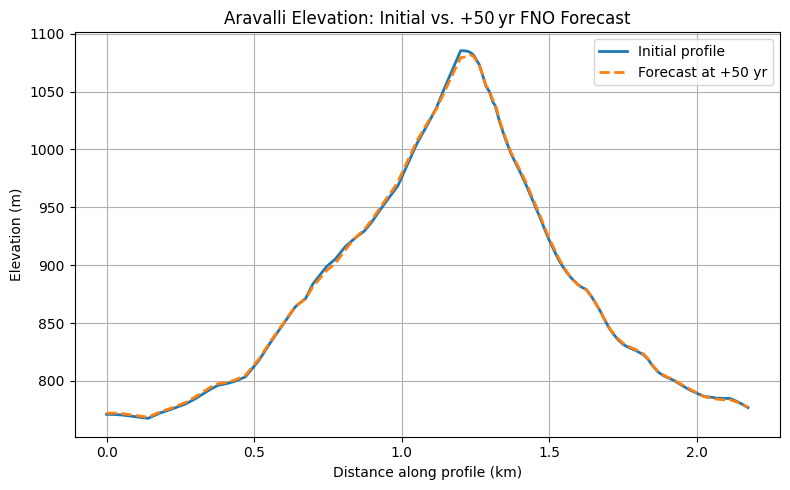

In [ ]:
forecast = np.load("aravalli_50yr_fno.npy")
import matplotlib.pyplot as plt
# 3. Extract initial and 50-year profiles
h_initial = forecast[0]    # at t = 0
h_50yr    = forecast[-1]   # at t = 50 years

# 4. Plot them
plt.figure(figsize=(8, 5))
plt.plot(x, h_initial, label="Initial profile", linewidth=2)
plt.plot(x, h_50yr,    label="Forecast at +50 yr", linewidth=2, linestyle="--")
plt.xlabel("Distance along profile (km)")
plt.ylabel("Elevation (m)")
plt.title("Aravalli Elevation: Initial vs. +50 yr FNO Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

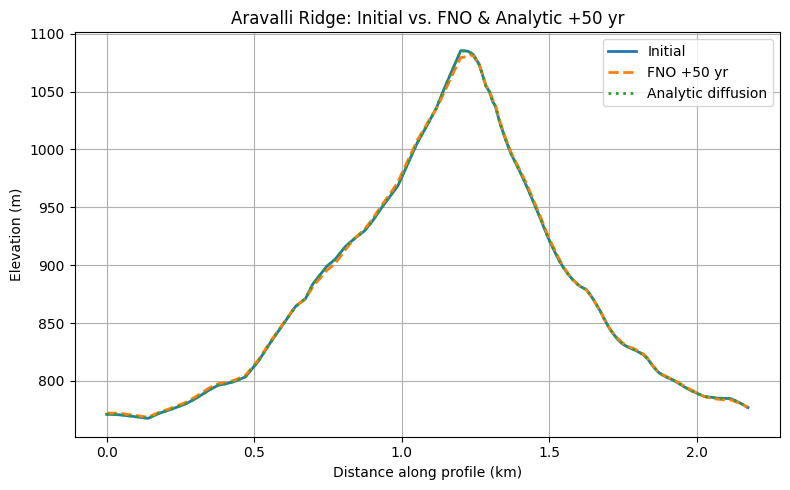

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Aravalli GPS + elevation, build along-profile x in meters
df = pd.read_csv("Aravalli range_1.txt", sep="\t")
lat = np.deg2rad(df["latitude"].values)
lon = np.deg2rad(df["longitude"].values)

def haversine(lat1, lon1, lat2, lon2, R=6371e3):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c  # meters

dist = [0.0]
for i in range(1, len(lat)):
    dist.append(haversine(lat[i-1], lon[i-1], lat[i], lon[i]))
x = np.cumsum(dist)        # meters
x_km = x / 1e3              # for plotting in km

# 2. Load FNO forecast (shape: 51 × n_x)
forecast = np.load("aravalli_50yr_fno.npy")
h_init = forecast[0]        # t=0
h_fno  = forecast[-1]       # t=50 yr

# 3. Compute analytic 50-yr diffusion solution via FFT
D     = 0.01                # m²/yr (realistic)
years = 50.0
n_x   = len(x)
dx    = (x.max() - x.min())/(n_x - 1)

k = 2*np.pi*np.fft.rfftfreq(n_x, d=dx)
H0 = np.fft.rfft(h_init)
H50 = H0 * np.exp(-D * (k**2) * years)
h_analytic = np.fft.irfft(H50, n=n_x)

# 4. Plot all three curves
plt.figure(figsize=(8,5))
plt.plot(x_km, h_init,     label="Initial",            lw=2)
plt.plot(x_km, h_fno,      label="FNO +50 yr",         lw=2, ls="--")
plt.plot(x_km, h_analytic, label="Analytic diffusion", lw=2, ls=":")
plt.xlabel("Distance along profile (km)")
plt.ylabel("Elevation (m)")
plt.title("Aravalli Ridge: Initial vs. FNO & Analytic +50 yr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Revised FNO

Training FNO to learn one-year diffusion step …
 Ep   1/150 — MSE 9.797e-01
 Ep  25/150 — MSE 8.158e-05
 Ep  50/150 — MSE 6.311e-05
 Ep  75/150 — MSE 5.370e-05
 Ep 100/150 — MSE 4.608e-05
 Ep 125/150 — MSE 3.937e-05
 Ep 150/150 — MSE 3.598e-05

FNO forecast stats: min= -1.1755248 max= 1.8487086 n_nan= 0 n_inf= 0

Error at T=50 yr:
 Analytic vs FD  → 2.802e-01 m
 Analytic vs FNO → 2.998e+00 m


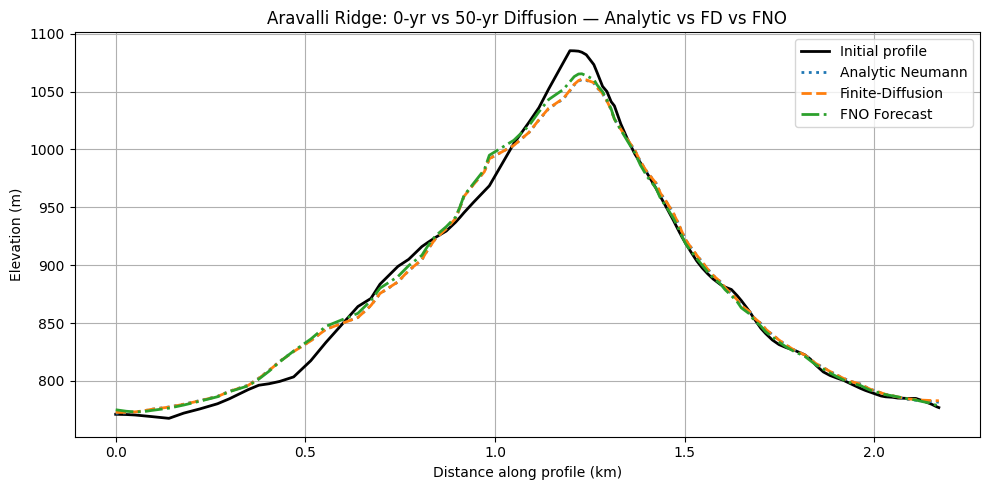

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from scipy.fftpack import dct, idct
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 1) DATA LOADING & PROJECTION
# -----------------------------------------------------------------------------
def load_profile(fn, sep="\t"):
    df = pd.read_csv(fn, sep=sep)
    # make sure these match your TSV headers exactly:
    for col in ("latitude", "longitude", "altitude (m)"):
        if col not in df.columns:
            raise RuntimeError(f"Missing column: {col}")
    df = df.dropna(subset=["latitude","longitude","altitude (m)"])
    return df["latitude"].values, df["longitude"].values, df["altitude (m)"].values

def to_local_xy(lat, lon):
    utm_zone = int(np.floor((lon.mean() + 180)/6) + 1)
    proj_str = f"epsg:326{utm_zone:02d}"
    transformer = Transformer.from_crs("epsg:4326", proj_str, always_xy=True)
    x, y = transformer.transform(lon, lat)
    return x, y

lat, lon, elev = load_profile("Aravalli range_1.txt")
x, y = to_local_xy(lat, lon)
s = np.hstack([0, np.cumsum(np.hypot(np.diff(x), np.diff(y)))])
dx = np.mean(np.diff(s))
N  = len(s)

# -----------------------------------------------------------------------------
# 2) ANALYTIC DIFFUSION (Neumann BC) → “GROUND TRUTH”
# -----------------------------------------------------------------------------
def analytic_neumann(h0, D, t, dx):
    H0  = dct(h0, type=2, norm="ortho")
    k   = np.arange(len(h0))
    L   = dx*(len(h0)-1)
    lam = (np.pi * k / L)**2
    Ht  = H0 * np.exp(-D * lam * t)
    return idct(Ht, type=2, norm="ortho")

D = 100   # m²/yr (bumped up for visible effect)
T = 50     # years

h0     = elev.copy().astype(np.float32)
h_true = np.zeros((T+1, N), dtype=np.float32)
for t in range(T+1):
    h_true[t] = analytic_neumann(h0, D, t, dx)

# -----------------------------------------------------------------------------
# 3) NORMALIZE BEFORE FNO
# -----------------------------------------------------------------------------
mean, std = h_true.mean(), h_true.std()
h_norm    = (h_true - mean) / std

# -----------------------------------------------------------------------------
# 4) FINITE‐DIFFERENCE SOLVER
# -----------------------------------------------------------------------------
def fd_neumann(h0, D, t, dx, dt=0.1):
    u     = h0.copy()
    alpha = D * dt / dx**2
    if alpha > 0.5:
        raise RuntimeError(f"Unstable FD: α={alpha:.3f}")
    steps = int(np.ceil(t/dt))
    for _ in range(steps):
        v     = u.copy()
        v[1:-1] += alpha*(u[2:]-2*u[1:-1]+u[:-2])
        v[0], v[-1] = v[1], v[-2]
        u = v
    return u

# -----------------------------------------------------------------------------
# 5) FNO MODULES
# -----------------------------------------------------------------------------
class SpectralConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, modes):
        super().__init__()
        self.in_ch, self.out_ch, self.modes = in_ch, out_ch, modes
        self.scale = 1/(in_ch*out_ch)
        self.W = nn.Parameter(self.scale * torch.rand(in_ch, out_ch, modes, 2))

    def compl_mul1d(self, x, w):
        x_ft = torch.fft.rfft(x)
        w_c  = torch.complex(w[...,0], w[...,1])
        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = torch.einsum("bic, ioc->boc",
                                                 x_ft[:, :, :self.modes],
                                                 w_c)
        return torch.fft.irfft(out_ft, n=x.shape[-1])

    def forward(self, x):
        return self.compl_mul1d(x, self.W)

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.fc0   = nn.Linear(1, width)
        self.conv0 = SpectralConv1d(width, width, modes)
        self.w0    = nn.Conv1d(width, width, 1)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.w1    = nn.Conv1d(width, width, 1)
        self.conv2 = SpectralConv1d(width, width, modes)
        self.w2    = nn.Conv1d(width, width, 1)
        self.fc1   = nn.Linear(width, 128)
        self.fc2   = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)            # [B, L, 1]
        x = self.fc0(x)                # [B, L, W]
        x = x.permute(0,2,1)           # [B, W, L]
        for conv, w in [(self.conv0,self.w0),
                        (self.conv1,self.w1),
                        (self.conv2,self.w2)]:
            x = nn.functional.gelu(conv(x) + w(x))
        x = x.permute(0,2,1)           # [B, L, W]
        x = nn.functional.gelu(self.fc1(x))
        return self.fc2(x).squeeze(-1) # [B, L]

# -----------------------------------------------------------------------------
# 6) DATASET & TRAINING
# -----------------------------------------------------------------------------
class DiffusionDataset(Dataset):
    def __init__(self, data):
        self.x = data[:-1]
        self.y = data[1:]
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

dataset = DiffusionDataset(h_norm)
loader  = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = FNO1d(modes=16, width=64).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
mse    = nn.MSELoss()

print("Training FNO to learn one-year diffusion step …")
for ep in range(1, 151):
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = mse(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()*xb.size(0)
    total_loss /= len(dataset)
    if ep % 25 == 0 or ep == 1:
        print(f" Ep {ep:3d}/150 — MSE {total_loss:.3e}")

# -----------------------------------------------------------------------------
# 7) FORECAST + STATS CHECK
# -----------------------------------------------------------------------------
with torch.no_grad():
    h = torch.tensor(h_norm[0], device=device).unsqueeze(0)  # [1, N]
    for _ in range(T):
        h = model(h)
h_norm50 = h.squeeze(0).cpu().numpy()

print("\nFNO forecast stats:",
      "min=", np.nanmin(h_norm50),
      "max=", np.nanmax(h_norm50),
      "n_nan=", np.isnan(h_norm50).sum(),
      "n_inf=", np.isinf(h_norm50).sum())

# rescale back to meters
h_fno50 = h_norm50 * std + mean
h_an50  = h_true[-1]
h_fd50  = fd_neumann(h0, D, T, dx)

print("\nError at T=50 yr:")
print(f" Analytic vs FD  → {np.linalg.norm(h_an50-h_fd50)/np.sqrt(N):.3e} m")
print(f" Analytic vs FNO → {np.linalg.norm(h_an50-h_fno50)/np.sqrt(N):.3e} m")

# -----------------------------------------------------------------------------
# 8) PLOT (with initial profile)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(s/1e3,   h0,      label="Initial profile",     lw=2, c="k")
plt.plot(s/1e3,   h_an50,  label="Analytic Neumann",    lw=2, ls=":")
plt.plot(s/1e3,   h_fd50,  label="Finite-Diffusion",    lw=2, ls="--")
plt.plot(s/1e3,   h_fno50, label="FNO Forecast",        lw=2, ls="-.")
plt.xlabel("Distance along profile (km)")
plt.ylabel("Elevation (m)")
plt.title("Aravalli Ridge: 0-yr vs 50-yr Diffusion — Analytic vs FD vs FNO")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


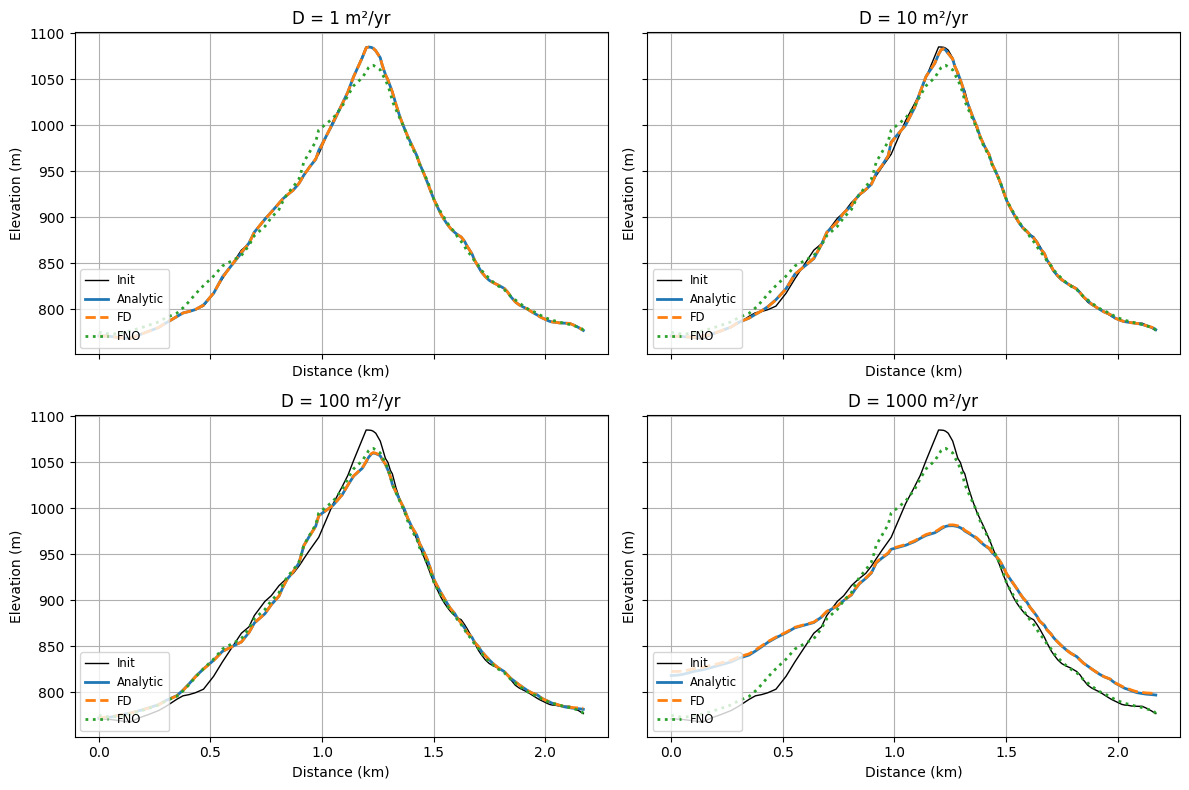

In [ ]:
# -----------------------------------------------------------------------------
# 9) PARAMETER STUDY: VARY D AND PLOT WITH FNO
# -----------------------------------------------------------------------------
Ds    = [1, 10, 100, 1000]  # m²/yr
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, D_test in zip(axes, Ds):
    # 1) analytic
    h_an = analytic_neumann(h0, D_test, T, dx)

    # 2) finite-difference
    try:
        h_fd = fd_neumann(h0, D_test, T, dx, dt=0.1)
    except RuntimeError:
        h_fd = np.full_like(h0, np.nan)

    # 3) FNO forecast (using the model trained at D=0.1)
    h_norm_init = (h0 - mean) / std
    h_t = torch.tensor(h_norm_init, device=device).unsqueeze(0)  # [1, N]
    model.eval()
    with torch.no_grad():
        for _ in range(T):
            h_t = model(h_t)
    h_fno = (h_t.squeeze(0).cpu().numpy() * std) + mean

    # 4) plot everything
    ax.plot(s/1e3, h0,     color="k",        lw=1,  label="Init")
    ax.plot(s/1e3, h_an,   lw=2,             label="Analytic")
    ax.plot(s/1e3, h_fd,   lw=2, ls="--",     label="FD")
    ax.plot(s/1e3, h_fno,  lw=2, ls=":",      label="FNO")
    ax.set_title(f"D = {D_test} m²/yr")
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Elevation (m)")
    ax.grid(True)
    ax.legend(loc="lower left", fontsize="small")

plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------------------------------------------
# 0) Choose a list of diffusivities for training
# -----------------------------------------------------------------------------
D_list = [0.1, 1.0, 10.0]   # you can add more
T      = 50                 # years

# -----------------------------------------------------------------------------
# 1) Build “ground truth” for each D in D_list
# -----------------------------------------------------------------------------
all_profiles = []
all_D_vals   = []
for D in D_list:
    # build analytic Neumann snapshots at this D
    h_true_D = np.zeros((T+1, N), dtype=np.float32)
    for t in range(T+1):
        h_true_D[t] = analytic_neumann(h0, D, t, dx)
    # store
    all_profiles.append(h_true_D)           # shape (T+1, N)
    all_D_vals  .append(np.full((T+1,), D)) # shape (T+1,)
# concatenate along time+parameter axis:
h_all = np.concatenate(all_profiles, axis=0)   # shape (len(D_list)*(T+1), N)
D_all = np.concatenate(all_D_vals , axis=0)    # shape (len(D_list)*(T+1),)

# -----------------------------------------------------------------------------
# 2) Normalize h *and* D
# -----------------------------------------------------------------------------
h_mean, h_std = h_all.mean(), h_all.std()
D_mean, D_std = D_all.mean(), D_all.std()

h_norm = (h_all - h_mean)/h_std
D_norm = (D_all - D_mean)/D_std

# we will predict h_norm[t+1] from [h_norm[t], D_norm[t]]
# so build paired slices:
X_h = h_norm[:-1]    # inputs
X_D = D_norm[:-1][:,None]  # broadcast to shape (samples,1)
Y   = h_norm[1:]     # targets

# -----------------------------------------------------------------------------
# 3) Dataset now returns (h, D) → h_next
# -----------------------------------------------------------------------------
class ConditionalDiffusionDataset(Dataset):
    def __init__(self, H, D, Y):
        # H: [S, N], D: [S,1], Y: [S, N]
        self.H = H
        self.D = D
        self.Y = Y
    def __len__(self): return len(self.H)
    def __getitem__(self, i):
        # concatenate along channel dimension:
        # we will end up with shape [2, N]
        h = self.H[i]           # shape (N,)
        d = np.full_like(h, self.D[i,0])  # shape (N,)
        inp = np.stack([h, d], axis=0)     # shape (2, N)
        return inp.astype(np.float32), self.Y[i]

dataset = ConditionalDiffusionDataset(X_h, X_D, Y)
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

# -----------------------------------------------------------------------------
# 4) Modify your FNO to take 2 channels in
# -----------------------------------------------------------------------------
class FNO1d_Cond(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        # now input channels = 2
        self.fc0   = nn.Linear(2, width)
        # rest is unchanged
        self.conv0 = SpectralConv1d(width, width, modes)
        self.w0    = nn.Conv1d(width, width, 1)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.w1    = nn.Conv1d(width, width, 1)
        self.conv2 = SpectralConv1d(width, width, modes)
        self.w2    = nn.Conv1d(width, width, 1)
        self.fc1   = nn.Linear(width, 128)
        self.fc2   = nn.Linear(128, 1)

    def forward(self, x):
        # x: [B, C=2, N]
        x = x.permute(0,2,1)            # [B, N, 2]
        x = self.fc0(x)                 # [B, N, W]
        x = x.permute(0,2,1)            # [B, W, N]
        for conv, w in [(self.conv0,self.w0),
                        (self.conv1,self.w1),
                        (self.conv2,self.w2)]:
            x = nn.functional.gelu(conv(x) + w(x))
        x = x.permute(0,2,1)            # [B, N, W]
        x = nn.functional.gelu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [B, N]

model = FNO1d_Cond(modes=16, width=64).to(device)

# -----------------------------------------------------------------------------
# 5) Train exactly as before
# -----------------------------------------------------------------------------
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
mse = nn.MSELoss()

for ep in range(1,151):
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = mse(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    total /= len(dataset)
    if ep%25==0 or ep==1:
        print(f"Ep {ep:3d}/150 — MSE {total:.3e}")

# -----------------------------------------------------------------------------
# 6) Forecast at any new D* by normalizing D*, stacking, and looping
# -----------------------------------------------------------------------------
def forecast_with_D(model, h0, D_val):
    d_norm = (D_val - D_mean)/D_std
    h = (h0 - h_mean)/h_std
    h_t = torch.tensor(h, device=device).unsqueeze(0)   # [1, N]
    for _ in range(T):
        # build input tensor [1,2,N]
        inpt = torch.stack([
            h_t.squeeze(0),
            torch.full_like(h_t.squeeze(0), d_norm)
        ], dim=0).unsqueeze(0)
        h_t = model(inpt)
    # rescale
    return (h_t.squeeze(0).cpu().numpy()*h_std + h_mean)

# example: forecast for D*=100 m2/yr
h_fno100 = forecast_with_D(model, h0, 100.0)


Ep   1/150 — MSE 9.866e-01
Ep  25/150 — MSE 1.982e-04
Ep  50/150 — MSE 1.916e-04
Ep  75/150 — MSE 1.851e-04
Ep 100/150 — MSE 1.771e-04
Ep 125/150 — MSE 1.674e-04
Ep 150/150 — MSE 1.551e-04


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Ep   1/150 — MSE 4.161e-01
Ep  25/150 — MSE 4.751e-06
Ep  50/150 — MSE 4.530e-07
Ep  75/150 — MSE 2.499e-07
Ep 100/150 — MSE 2.043e-07
Ep 125/150 — MSE 4.418e-07
Ep 150/150 — MSE 7.938e-06


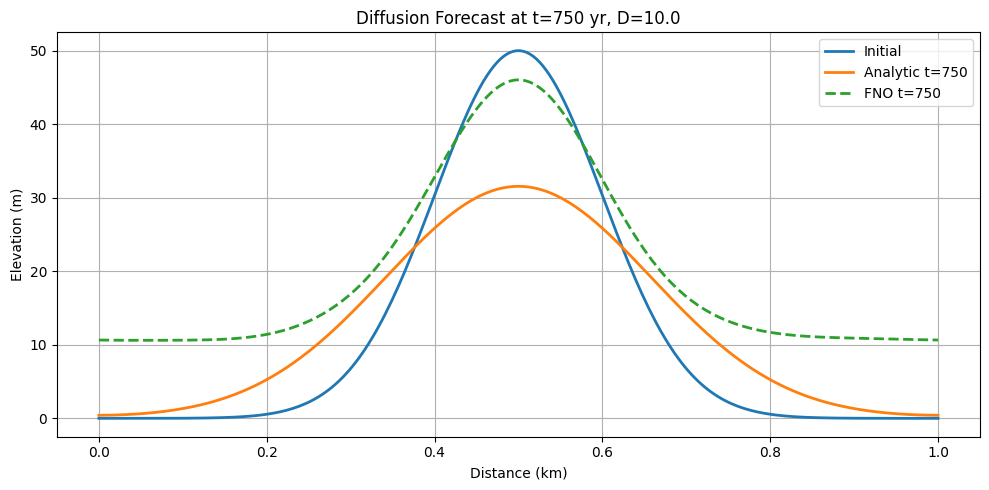

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Generate training data: (h0, D, t) -> ht
# -----------------------------------------------------------------------------
def analytic_neumann(h0, D, t, dx):
    H0 = dct(h0, type=2, norm="ortho")
    k = np.arange(len(h0))
    L = dx*(len(h0)-1)
    lam = (np.pi * k / L)**2
    Ht = H0 * np.exp(-D * lam * t)
    ht = idct(Ht, type=2, norm="ortho")
    return ht

# Sample hill profile and parameters
N = 256
L = 1000.0  # total length in meters
x = np.linspace(0, L, N)
h0 = 50 * np.exp(-((x - L/2)**2)/(2*(L/10)**2))  # Gaussian hill

D_list = [0.1, 1.0, 10.0]
T_max = 50

dx = x[1] - x[0]
X_in, Y_out = [], []
for D in D_list:
    for t in range(1, T_max+1):
        ht = analytic_neumann(h0, D, t, dx)
        D_chan = np.full_like(h0, D)
        t_chan = np.full_like(h0, t)
        inp = np.stack([h0, D_chan, t_chan], axis=0)  # shape (3, N)
        X_in.append(inp)
        Y_out.append(ht)

X_in = np.array(X_in, dtype=np.float32)
Y_out = np.array(Y_out, dtype=np.float32)

# Normalize inputs
h_mean, h_std = X_in[:,0].mean(), X_in[:,0].std()
X_in[:,0] = (X_in[:,0] - h_mean) / h_std
D_mean, D_std = np.mean(D_list), np.std(D_list)
X_in[:,1] = (X_in[:,1] - D_mean) / D_std
X_in[:,2] = (X_in[:,2] - T_max/2) / (T_max/2)
Y_out = (Y_out - h_mean) / h_std

# -----------------------------------------------------------------------------
# 2. Dataset & Model
# -----------------------------------------------------------------------------
class TimeAwareDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

dataset = TimeAwareDataset(X_in, Y_out)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

class SpectralConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, modes):
        super().__init__()
        self.in_ch, self.out_ch, self.modes = in_ch, out_ch, modes
        self.scale = 1 / (in_ch*out_ch)
        self.W = nn.Parameter(self.scale * torch.rand(in_ch, out_ch, modes, 2))

    def compl_mul1d(self, input, weights):
        B, C, L = input.shape
        input_ft = torch.fft.rfft(input)
        w = torch.complex(weights[...,0], weights[...,1])
        out_ft = torch.zeros(B, self.out_ch, input_ft.shape[-1], dtype=torch.cfloat, device=input.device)
        out_ft[:,:,:self.modes] = torch.einsum("bic, ioc -> boc", input_ft[:,:,:self.modes], w)
        return torch.fft.irfft(out_ft, n=L)

    def forward(self, x):
        return self.compl_mul1d(x, self.W)

class FNO1d_Direct(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.fc0 = nn.Linear(3, width)
        self.conv0 = SpectralConv1d(width, width, modes)
        self.w0 = nn.Conv1d(width, width, 1)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.w1 = nn.Conv1d(width, width, 1)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0,2,1)    # [B, N, 3]
        x = self.fc0(x)         # [B, N, W]
        x = x.permute(0,2,1)    # [B, W, N]
        x = nn.functional.gelu(self.conv0(x) + self.w0(x))
        x = nn.functional.gelu(self.conv1(x) + self.w1(x))
        x = x.permute(0,2,1)    # [B, N, W]
        x = nn.functional.gelu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [B, N]

# -----------------------------------------------------------------------------
# 3. Training Loop
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d_Direct(modes=16, width=64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for ep in range(1, 151):
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = mse(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    total /= len(dataset)
    if ep % 25 == 0 or ep == 1:
        print(f"Ep {ep:3d}/150 — MSE {total:.3e}")

# -----------------------------------------------------------------------------
# 4. Evaluation: Predict for new t and D
# -----------------------------------------------------------------------------
def predict_fno(h0, D, t):
    h0n = (h0 - h_mean) / h_std
    Dn = (D - D_mean) / D_std
    tn = (t - T_max/2) / (T_max/2)
    D_chan = np.full_like(h0n, Dn)
    t_chan = np.full_like(h0n, tn)
    inp = np.stack([h0n, D_chan, t_chan], axis=0).astype(np.float32)
    inp = torch.tensor(inp).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(inp).cpu().numpy()[0]
    return pred * h_std + h_mean

# -----------------------------------------------------------------------------
# 5. Plot predictions vs analytic
# -----------------------------------------------------------------------------


Ep   1/150 — MSE 4.676e-01
Ep  25/150 — MSE 9.381e-06
Ep  50/150 — MSE 2.848e-06
Ep  75/150 — MSE 2.901e-06
Ep 100/150 — MSE 5.184e-06
Ep 125/150 — MSE 1.100e-04
Ep 150/150 — MSE 9.375e-06


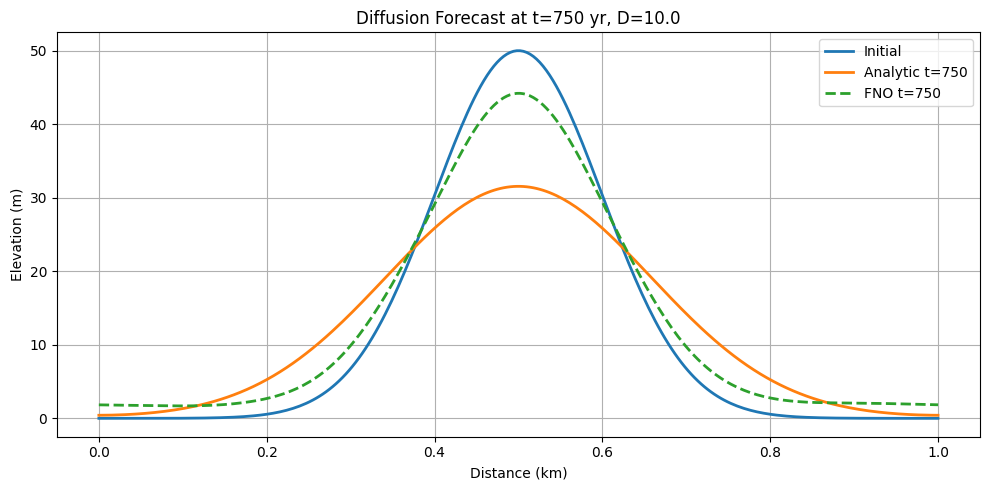

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Generate training data: (h0, D, log(t+1)) -> ht
# -----------------------------------------------------------------------------
def analytic_neumann(h0, D, t, dx):
    H0 = dct(h0, type=2, norm="ortho")
    k = np.arange(len(h0))
    L = dx*(len(h0)-1)
    lam = (np.pi * k / L)**2
    Ht = H0 * np.exp(-D * lam * t)
    ht = idct(Ht, type=2, norm="ortho")
    return ht

# Sample hill profile and parameters
N = 256
L = 1000.0  # total length in meters
x = np.linspace(0, L, N)
h0 = 50 * np.exp(-((x - L/2)**2)/(2*(L/10)**2))  # Gaussian hill

D_list = [0.1, 1.0, 10.0]
T_max = 50

dx = x[1] - x[0]
X_in, Y_out = [], []
for D in D_list:
    for t in range(1, T_max+1):
        ht = analytic_neumann(h0, D, t, dx)
        D_chan = np.full_like(h0, D)
        t_chan = np.full_like(h0, np.log(t + 1))  # log(t+1) encoding
        inp = np.stack([h0, D_chan, t_chan], axis=0)  # shape (3, N)
        X_in.append(inp)
        Y_out.append(ht)

X_in = np.array(X_in, dtype=np.float32)
Y_out = np.array(Y_out, dtype=np.float32)

# Normalize inputs
h_mean, h_std = X_in[:,0].mean(), X_in[:,0].std()
X_in[:,0] = (X_in[:,0] - h_mean) / h_std
D_mean, D_std = np.mean(D_list), np.std(D_list)
X_in[:,1] = (X_in[:,1] - D_mean) / D_std
t_log_vals = X_in[:,2]
t_mean, t_std = t_log_vals.mean(), t_log_vals.std()
X_in[:,2] = (X_in[:,2] - t_mean) / t_std
Y_out = (Y_out - h_mean) / h_std

# -----------------------------------------------------------------------------
# 2. Dataset & Model
# -----------------------------------------------------------------------------
class TimeAwareDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

dataset = TimeAwareDataset(X_in, Y_out)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

class SpectralConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, modes):
        super().__init__()
        self.in_ch, self.out_ch, self.modes = in_ch, out_ch, modes
        self.scale = 1 / (in_ch*out_ch)
        self.W = nn.Parameter(self.scale * torch.rand(in_ch, out_ch, modes, 2))

    def compl_mul1d(self, input, weights):
        B, C, L = input.shape
        input_ft = torch.fft.rfft(input)
        w = torch.complex(weights[...,0], weights[...,1])
        out_ft = torch.zeros(B, self.out_ch, input_ft.shape[-1], dtype=torch.cfloat, device=input.device)
        out_ft[:,:,:self.modes] = torch.einsum("bic, ioc -> boc", input_ft[:,:,:self.modes], w)
        return torch.fft.irfft(out_ft, n=L)

    def forward(self, x):
        return self.compl_mul1d(x, self.W)

class FNO1d_Direct(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.fc0 = nn.Linear(3, width)
        self.conv0 = SpectralConv1d(width, width, modes)
        self.w0 = nn.Conv1d(width, width, 1)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.w1 = nn.Conv1d(width, width, 1)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0,2,1)    # [B, N, 3]
        x = self.fc0(x)         # [B, N, W]
        x = x.permute(0,2,1)    # [B, W, N]
        x = nn.functional.gelu(self.conv0(x) + self.w0(x))
        x = nn.functional.gelu(self.conv1(x) + self.w1(x))
        x = x.permute(0,2,1)    # [B, N, W]
        x = nn.functional.gelu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [B, N]

# -----------------------------------------------------------------------------
# 3. Training Loop
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d_Direct(modes=16, width=64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for ep in range(1, 151):
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = mse(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    total /= len(dataset)
    if ep % 25 == 0 or ep == 1:
        print(f"Ep {ep:3d}/150 — MSE {total:.3e}")

# -----------------------------------------------------------------------------
# 4. Evaluation: Predict for new t and D
# -----------------------------------------------------------------------------
def predict_fno(h0, D, t):
    h0n = (h0 - h_mean) / h_std
    Dn = (D - D_mean) / D_std
    tn = (np.log(t + 1) - t_mean) / t_std
    D_chan = np.full_like(h0n, Dn)
    t_chan = np.full_like(h0n, tn)
    inp = np.stack([h0n, D_chan, t_chan], axis=0).astype(np.float32)
    inp = torch.tensor(inp).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(inp).cpu().numpy()[0]
    return pred * h_std + h_mean

# -----------------------------------------------------------------------------
# 5. Plot predictions vs analytic
# -----------------------------------------------------------------------------
D_test = 10.0
t_test = 750
h_pred = predict_fno(h0, D_test, t_test)
h_true = analytic_neumann(h0, D_test, t_test, dx)

plt.figure(figsize=(10,5))
plt.plot(x/1000, h0, label="Initial", lw=2)
plt.plot(x/1000, h_true, label=f"Analytic t={t_test}", lw=2)
plt.plot(x/1000, h_pred, label=f"FNO t={t_test}", lw=2, ls="--")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title(f"Diffusion Forecast at t={t_test} yr, D={D_test}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PINO

Epoch 1/100, Loss: 1.430e-03
Epoch 10/100, Loss: 1.292e-06
Epoch 20/100, Loss: 3.390e-07
Epoch 30/100, Loss: 1.723e-07
Epoch 40/100, Loss: 1.167e-07
Epoch 50/100, Loss: 1.542e-07
Epoch 60/100, Loss: 7.129e-08
Epoch 70/100, Loss: 6.483e-08
Epoch 80/100, Loss: 6.750e-08
Epoch 90/100, Loss: 7.084e-08
Epoch 100/100, Loss: 4.415e-08


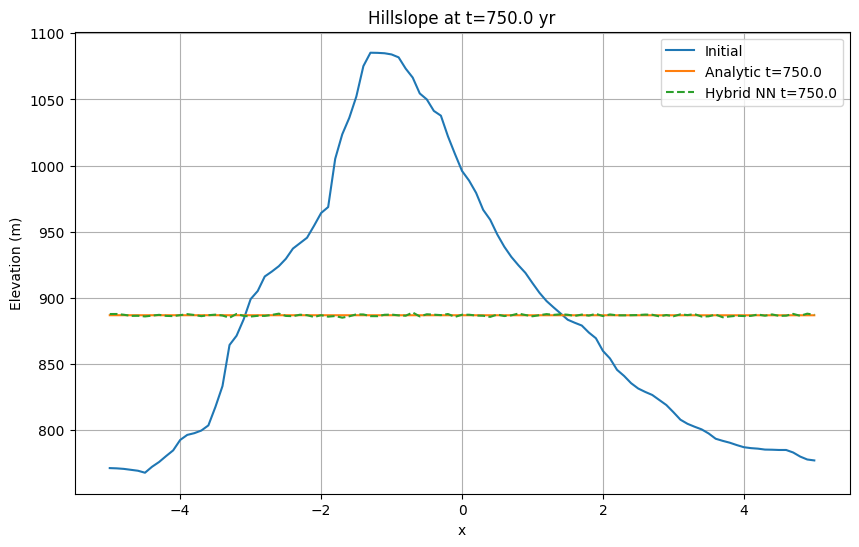

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# -----------------------
# 1. Load & normalize data
# -----------------------
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')
altitudes = data['altitude (m)'].values.astype(np.float32)
# Normalize elevation to zero mean and unit std
h0 = (altitudes - altitudes.mean()) / altitudes.std()
N = h0.shape[0]
L = 10.0   # domain length (from x=-5 to 5)
dx = L / (N - 1)

# -----------------------
# 2. DCT and analytic decay
# -----------------------
def compute_modes(h):
    return dct(h, type=2, norm='ortho')

def analytic_decay(A, D, t, L):
    k = np.arange(A.shape[-1]) * np.pi / L
    return A * np.exp(-D * k**2 * t)

# Precompute initial modes
A0 = compute_modes(h0)

# -----------------------
# 3. Synthetic dataset
# -----------------------
class SpectralResidualDataset(Dataset):
    def __init__(self, A0, D, T_samples, L):
        self.inputs = []  # analytic modes at t
        self.targets = [] # true modes at t
        for t in T_samples:
            At = analytic_decay(A0, D, t, L)
            # true profile via IDCT (should match analytic but included for completeness)
            h_true = idct(At, type=2, norm='ortho')
            A_true = compute_modes(h_true)
            self.inputs.append(At.astype(np.float32))
            self.targets.append((A_true - At).astype(np.float32))  # residual
        self.inputs = np.stack(self.inputs)
        self.targets = np.stack(self.targets)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Diffusion parameters
diffusion_coeff = 0.1
T_max = 100.0
T_samples = np.linspace(1.0, T_max, num=100, dtype=np.float32)

# Create dataset and loader
dataset = SpectralResidualDataset(A0, diffusion_coeff, T_samples, L)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# -----------------------
# 4. Residual network
# -----------------------
class ResidualNet(nn.Module):
    def __init__(self, num_modes, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_modes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_modes)
        )

    def forward(self, A):
        return self.net(A)

# Instantiate model, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualNet(num_modes=N).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -----------------------
# 5. Training loop
# -----------------------
epochs = 100
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    for A_analytic, residual in loader:
        A_analytic = A_analytic.to(device)
        residual   = residual.to(device)

        # predict residual
        pred_res = model(A_analytic)
        loss = criterion(pred_res, residual)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * A_analytic.size(0)

    epoch_loss /= len(dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.3e}")

# -----------------------
# 6. Evaluation at large t
# -----------------------
t_test = 750.0
A_t = analytic_decay(A0, diffusion_coeff, t_test, L).astype(np.float32)

model.eval()
with torch.no_grad():
    A_t_tensor = torch.tensor(A_t, device=device).unsqueeze(0)
    pred_residual = model(A_t_tensor).cpu().numpy().squeeze()

# reconstruct profile
A_pred = A_t + pred_residual
h_pred = idct(A_pred, type=2, norm='ortho')
# true analytic
h_true = idct(A_t, type=2, norm='ortho')

# Denormalize back to meters
h_pred_m = h_pred * altitudes.std() + altitudes.mean()
h_true_m = h_true * altitudes.std() + altitudes.mean()

# plot results
x = np.linspace(-5, 5, N)
plt.figure(figsize=(10,6))
plt.plot(x, h0 * altitudes.std() + altitudes.mean(), label='Initial')
plt.plot(x, h_true_m, label=f'Analytic t={t_test}')
plt.plot(x, h_pred_m, '--', label=f'Hybrid NN t={t_test}')
plt.xlabel('x')
plt.ylabel('Elevation (m)')
plt.title(f'Hillslope at t={t_test} yr')
plt.legend(); plt.grid(True)
plt.show()

# Save model
torch.save(model.state_dict(), 'spectral_residual_model.pth')


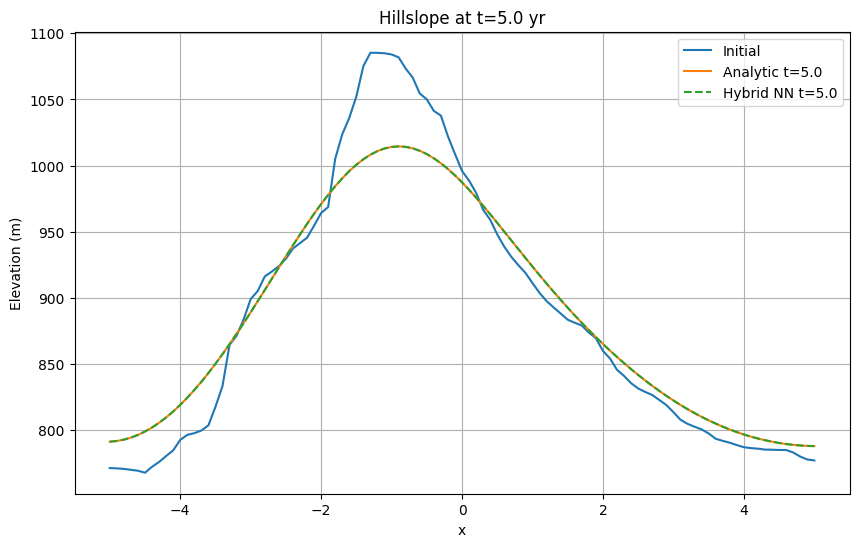

In [ ]:
t_test = 5.0
A_t = analytic_decay(A0, diffusion_coeff, t_test, L).astype(np.float32)

model.eval()
with torch.no_grad():
    A_t_tensor = torch.tensor(A_t, device=device).unsqueeze(0)
    pred_residual = model(A_t_tensor).cpu().numpy().squeeze()

# reconstruct profile
A_pred = A_t + pred_residual
h_pred = idct(A_pred, type=2, norm='ortho')
# true analytic
h_true = idct(A_t, type=2, norm='ortho')

# Denormalize back to meters
h_pred_m = h_pred * altitudes.std() + altitudes.mean()
h_true_m = h_true * altitudes.std() + altitudes.mean()

# plot results
x = np.linspace(-5, 5, N)
plt.figure(figsize=(10,6))
plt.plot(x, h0 * altitudes.std() + altitudes.mean(), label='Initial')
plt.plot(x, h_true_m, label=f'Analytic t={t_test}')
plt.plot(x, h_pred_m, '--', label=f'Hybrid NN t={t_test}')
plt.xlabel('x')
plt.ylabel('Elevation (m)')
plt.title(f'Hillslope at t={t_test} yr')
plt.legend(); plt.grid(True)
plt.show()

# Save model
torch.save(model.state_dict(), 'spectral_residual_model.pth')


Epoch 1/100, Loss: 1.247e-03
Epoch 10/100, Loss: 1.080e-06
Epoch 20/100, Loss: 3.735e-07
Epoch 30/100, Loss: 2.119e-07
Epoch 40/100, Loss: 1.270e-07
Epoch 50/100, Loss: 9.204e-08
Epoch 60/100, Loss: 1.397e-07
Epoch 70/100, Loss: 6.081e-08
Epoch 80/100, Loss: 4.305e-08
Epoch 90/100, Loss: 4.074e-08
Epoch 100/100, Loss: 3.791e-08
Sum of all true residuals across training set (per-mode sum): [ 5.1796954e-15 -6.5503158e-15  1.5903945e-14  3.6109353e-15
  5.3133754e-15 -3.5212252e-15  1.5145164e-15  3.6406307e-16
 -4.0944103e-15  2.6826733e-16  2.8442106e-15  1.0265565e-16
 -7.8103484e-16 -2.8206140e-15 -8.8782542e-16  2.5652075e-15
 -1.9416867e-16 -1.9927505e-15  2.7132809e-15  7.3956352e-15
 -1.5745115e-15 -2.1679645e-15  6.3084337e-15 -3.2248226e-15
 -3.4519396e-15  2.5492422e-15  5.4881605e-16  3.7210738e-15
 -2.2234170e-15 -1.0368511e-15 -2.4536607e-15 -1.5443430e-15
 -6.2098310e-15  4.8573854e-15 -2.4914028e-15 -6.1135079e-16
  2.6535239e-16  3.9991111e-15 -1.1456121e-15  1.0373711e-1

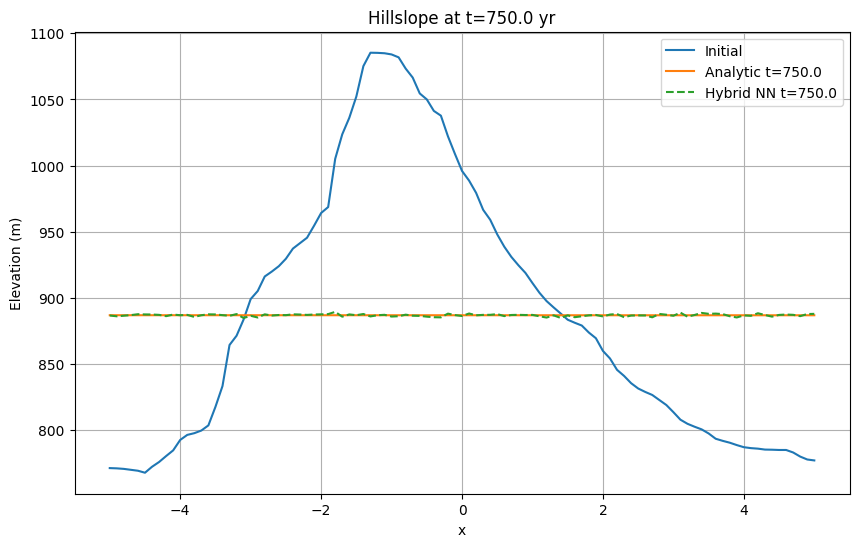

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# -----------------------
# 1. Load & normalize data
# -----------------------
filename = "Aravalli range_1.txt"
data = pd.read_csv(filename, sep='\t')
altitudes = data['altitude (m)'].values.astype(np.float32)
# Normalize elevation to zero mean and unit std
h0 = (altitudes - altitudes.mean()) / altitudes.std()
N = h0.shape[0]
L = 10.0   # domain length (from x=-5 to 5)
dx = L / (N - 1)

# -----------------------
# 2. DCT and analytic decay
# -----------------------
def compute_modes(h):
    return dct(h, type=2, norm='ortho')

def analytic_decay(A, D, t, L):
    k = np.arange(A.shape[-1]) * np.pi / L
    return A * np.exp(-D * k**2 * t)

# Precompute initial modes
A0 = compute_modes(h0)

# -----------------------
# 3. Synthetic dataset
# -----------------------
class SpectralResidualDataset(Dataset):
    def __init__(self, A0, D, T_samples, L):
        self.inputs = []  # analytic modes at t
        self.targets = [] # true residuals at t
        for t in T_samples:
            At = analytic_decay(A0, D, t, L)
            # true profile via IDCT (matches analytic for pure diffusion)
            h_true = idct(At, type=2, norm='ortho')
            A_true = compute_modes(h_true)
            self.inputs.append(At.astype(np.float32))
            self.targets.append((A_true - At).astype(np.float32))  # residual
        self.inputs = np.stack(self.inputs)
        self.targets = np.stack(self.targets)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Diffusion parameters
diffusion_coeff = 0.1
T_max = 100.0
T_samples = np.linspace(1.0, T_max, num=100, dtype=np.float32)

# Create dataset and loader
dataset = SpectralResidualDataset(A0, diffusion_coeff, T_samples, L)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# -----------------------
# 4. Residual network
# -----------------------
class ResidualNet(nn.Module):
    def __init__(self, num_modes, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_modes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_modes)
        )

    def forward(self, A):
        return self.net(A)

# Instantiate model, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualNet(num_modes=N).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -----------------------
# 5. Training loop
# -----------------------
epochs = 100
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    for A_analytic, residual in loader:
        A_analytic = A_analytic.to(device)
        residual   = residual.to(device)

        # predict residual
        pred_res = model(A_analytic)
        loss = criterion(pred_res, residual)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * A_analytic.size(0)

    epoch_loss /= len(dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.3e}")

# -----------------------
# 6. Evaluation at large t
# -----------------------
t_test = 750.0
A_t = analytic_decay(A0, diffusion_coeff, t_test, L).astype(np.float32)

model.eval()
with torch.no_grad():
    A_t_tensor = torch.tensor(A_t, device=device).unsqueeze(0)
    pred_residual = model(A_t_tensor).cpu().numpy().squeeze()

# Print sum of true and predicted residuals
sum_true_residual = np.sum(dataset.targets, axis=(0,))  # since targets nearly zero
sum_pred_residual = np.sum(pred_residual)
print(f"Sum of all true residuals across training set (per-mode sum): {sum_true_residual}")
print(f"Sum of predicted residuals at t={t_test}: {sum_pred_residual:.6e}")

# reconstruct profile
A_pred = A_t + pred_residual
h_pred = idct(A_pred, type=2, norm='ortho')
# true analytic
h_true = idct(A_t, type=2, norm='ortho')

# Denormalize back to meters
h_pred_m = h_pred * altitudes.std() + altitudes.mean()
h_true_m = h_true * altitudes.std() + altitudes.mean()

# plot results
x = np.linspace(-5, 5, N)
plt.figure(figsize=(10,6))
plt.plot(x, h0 * altitudes.std() + altitudes.mean(), label='Initial')
plt.plot(x, h_true_m, label=f'Analytic t={t_test}')
plt.plot(x, h_pred_m, '--', label=f'Hybrid NN t={t_test}')
plt.xlabel('x')
plt.ylabel('Elevation (m)')
plt.title(f'Hillslope at t={t_test} yr')
plt.legend(); plt.grid(True)
plt.show()

# Save model
torch.save(model.state_dict(), 'spectral_residual_model.pth')
